# Explainability of Vision Transformer (ViT) on RSNA After Localization

**Overview:**

In this notebook we evaluate the explainability of Vision Transformer (ViT-Tiny) model on a subset of the RSNA Pneumonia Chest X-ray dataset after localization. We use multiple explanation methods including Grad-CAM, Grad-CAM++, Integrated Gradients and Attention Rollout.



In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np
import os
import torch

class RSNADataset(Dataset):
    def __init__(self, csv_path, img_dir, img_size=224, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
        self.patient_ids = self.df['patientId'].unique()

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        img_path = os.path.join(self.img_dir, pid + ".png")
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Classification label
        rows = self.df[self.df['patientId'] == pid]
        label = int(rows['Target'].max())

        # Localization mask
        mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        for _, row in rows.iterrows():
            if row['Target'] == 1:
                if not np.isnan(row['x']):
                    x = int(row['x'] / row['x'].max() * self.img_size)
                    y = int(row['y'] / row['y'].max() * self.img_size)
                    w = int(row['width'] / row['width'].max() * self.img_size)
                    h = int(row['height'] / row['height'].max() * self.img_size)
                    mask[y:y+h, x:x+w] = 1.0
        mask = torch.tensor(mask).unsqueeze(0)  # [1,H,W]

        return img, torch.tensor(label, dtype=torch.float32), mask


## Localization Training:

A localization head was added on top of the fine-tuned ViT-Tiny to predict pixel-wise lung regions. The backbone was initially frozen, and only the localization head was trained using a BCE loss against bounding-box masks. The total loss combined classification and localization objectives, encouraging the model to make predictions based on lung-specific areas while preserving classification performance. 

In [ ]:
# =======================
#  Imports
# =======================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import timm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score

# =======================
#  Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_EPOCHS = 15
LR = 1e-4
CLASS_WEIGHT = 1.0
LOC_WEIGHT = 0.5   # lower to avoid dominating classification

IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
SAVE_PATH_FINE_TUNED = '/content/drive/MyDrive/RSNA_subset/vit_best_epoch/higher_accuracy_vit.pth'
SAVE_PATH_LOCALIZATION = '/content/drive/MyDrive/RSNA_subset/vit_localization_retrained.pth'

# =======================
#  Dataset
# =======================
class RSNA_Dataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.patient_ids = self.df['patientId'].unique()

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        img_path = os.path.join(self.img_dir, pid + ".png")
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Classification label
        rows = self.df[self.df['patientId'] == pid]
        label = int(rows['Target'].max())

        # Localization mask
        mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
        for _, row in rows.iterrows():
            if row['Target'] == 1:
                if not pd.isna(row['x']) and not pd.isna(row['y']) and not pd.isna(row['width']) and not pd.isna(row['height']):
                    x = int(max(0, row['x']))
                    y = int(max(0, row['y']))
                    w = int(max(0, row['width']))
                    h = int(max(0, row['height']))
                    # Clip to image bounds
                    x_end = min(IMG_SIZE, x + w)
                    y_end = min(IMG_SIZE, y + h)
                    mask[y:y_end, x:x_end] = 1.0
        mask = torch.tensor(mask).unsqueeze(0)  # [1,H,W]
        return img, torch.tensor(label, dtype=torch.float32), mask

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

dataset = RSNA_Dataset(CSV_PATH, IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# =======================
#  Load fine-tuned ViT
# =======================
vit_model = timm.create_model('vit_tiny_patch16_224', pretrained=False)
vit_model.head = nn.Sequential(
    nn.Linear(vit_model.head.in_features, 1),
    nn.Sigmoid()
)
vit_model.load_state_dict(torch.load(SAVE_PATH_FINE_TUNED, map_location=DEVICE))
vit_model.to(DEVICE)
vit_model.eval()

# =======================
#  Add localization head
# =======================
class ViT_Localization(nn.Module):
    def __init__(self, vit_model, img_size=224):
        super().__init__()
        self.vit = vit_model
        self.img_size = img_size

        # Localization head
        self.loc_head = nn.Sequential(
            nn.Linear(vit_model.embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, img_size * img_size)
        )

    def forward(self, x):
        B = x.size(0)
        # ViT patch embeddings
        x_tokens = self.vit.patch_embed(x)
        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x_tokens = torch.cat((cls_token, x_tokens), dim=1)
        x_tokens = self.vit.pos_drop(x_tokens + self.vit.pos_embed)
        for blk in self.vit.blocks:
            x_tokens = blk(x_tokens)
        x_tokens = self.vit.norm(x_tokens)

        # Classification output
        cls_out = torch.sigmoid(self.vit.head(x_tokens[:,0]))

        # Localization output
        patch_tokens = x_tokens[:,1:,:]
        loc_out = self.loc_head(patch_tokens)  # [B, num_patches, H*W]
        loc_out = loc_out.mean(1)
        loc_out = loc_out.view(B, 1, self.img_size, self.img_size)
        loc_out = torch.sigmoid(loc_out)
        return cls_out, loc_out

model_loc = ViT_Localization(vit_model).to(DEVICE)

# Freeze backbone initially
for param in model_loc.vit.parameters():
    param.requires_grad = False
for param in model_loc.loc_head.parameters():
    param.requires_grad = True

# =======================
#  Loss & Optimizer
# =======================
criterion_cls = nn.BCELoss()
criterion_loc = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_loc.parameters()), lr=LR)

# =======================
# Training loop with validation metrics
# =======================
best_val_auroc = 0.0
patience = 3
counter = 0

for epoch in range(NUM_EPOCHS):
    model_loc.train()
    running_loss = 0.0

    for imgs, labels, masks in tqdm(dataloader):
        imgs, labels, masks = imgs.to(DEVICE), labels.to(DEVICE).unsqueeze(1), masks.to(DEVICE)
        optimizer.zero_grad()
        cls_out, loc_out = model_loc(imgs)
        loss_cls = criterion_cls(cls_out, labels)
        loss_loc = criterion_loc(loc_out, masks)
        loss = CLASS_WEIGHT*loss_cls + LOC_WEIGHT*loss_loc
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    # ---------------- Validation metrics (simple) ----------------
    model_loc.eval()
    val_labels, val_preds = [], []
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels, masks in dataloader:
            imgs, labels, masks = imgs.to(DEVICE), labels.to(DEVICE).unsqueeze(1), masks.to(DEVICE)
            cls_out, loc_out = model_loc(imgs)
            loss_cls = criterion_cls(cls_out, labels)
            loss_loc = criterion_loc(loc_out, masks)
            loss = CLASS_WEIGHT*loss_cls + LOC_WEIGHT*loss_loc
            val_loss += loss.item() * imgs.size(0)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(cls_out.cpu().numpy())

    val_loss /= len(dataset)
    val_auroc = roc_auc_score(val_labels, val_preds)
    val_acc = accuracy_score((np.array(val_preds) > 0.5).astype(int), np.array(val_labels))
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {running_loss/len(dataset):.4f} Val Loss: {val_loss:.4f} Val AUROC: {val_auroc:.4f} Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        counter = 0
        torch.save(model_loc.state_dict(), SAVE_PATH_LOCALIZATION)
        print("Model improved. Saved checkpoint.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


Epoch [1/15] Train Loss: 0.8049 Val Loss: 0.6817 Val AUROC: 0.8626 Val Acc: 0.5000
Model improved. Saved checkpoint.


100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch [2/15] Train Loss: 0.6773 Val Loss: 0.6756 Val AUROC: 0.8626 Val Acc: 0.5000


100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [3/15] Train Loss: 0.6754 Val Loss: 0.6749 Val AUROC: 0.8626 Val Acc: 0.5000


100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch [4/15] Train Loss: 0.6749 Val Loss: 0.6746 Val AUROC: 0.8626 Val Acc: 0.5000
Early stopping triggered.


**Observation**:

Although the model was guided to focus on the lung region, the minimal decrease in training and validation loss suggests that it struggles to learn strong, meaningful relations from the lung patches. The plateau in validation AUROC and constant accuracy further indicate that the improvement is limited despite localization supervision. 

**Note:** Even though the accuracy is low, the AUROC is decently good, indicating that the model distinguishes between the two classes effectively. The discrepancy arises because AUROC evaluates ranking ability across all thresholds, while accuracy depends on a fixed decision threshold. After localization, the model's probability outputs become less confident and cluster near this threshold, leading to lower accuracy despite preserved discriminative power. 

## Grad-CAM: Visualizing model attention

**Concept**:

Grad-CAM highlights the image regions that are most responsible for the model's decision by tracing class-specific gradients throught the final feature maps.

**Purpose**:

In our notebook, we use it to interpret spatial focus in the first LayerNorm layer of the final Transformer encoder block (`model.blocks[-1].norm1`). This is the deepest feature extraction layer before the final normalization and classification head in ViT-Tiny.


**Quick references**
- Selvaraju et al., *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization* (2017).  
- `pytorch-grad-cam` (Jacob Gildenblat) — used for production-ready Grad-CAM utilities.



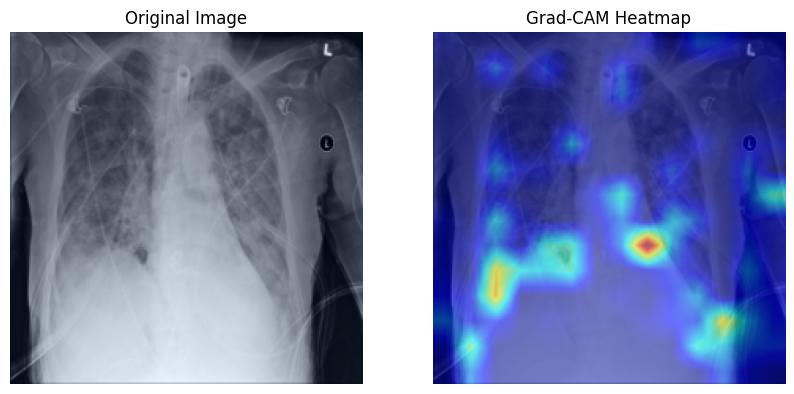

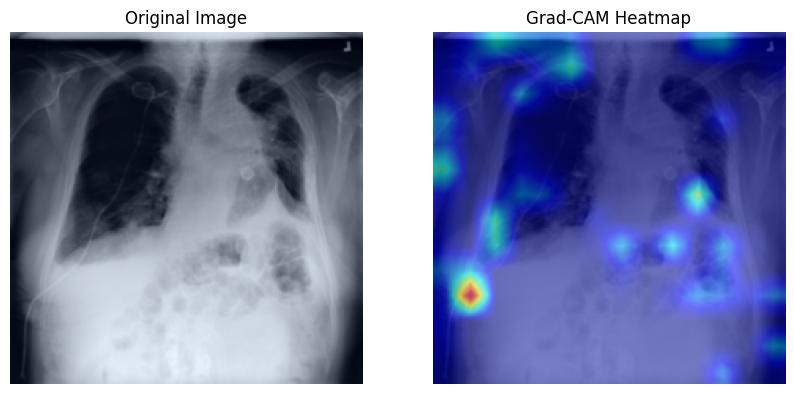

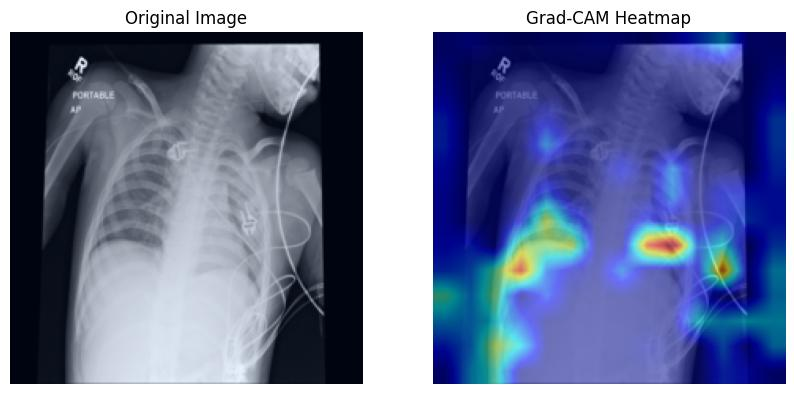

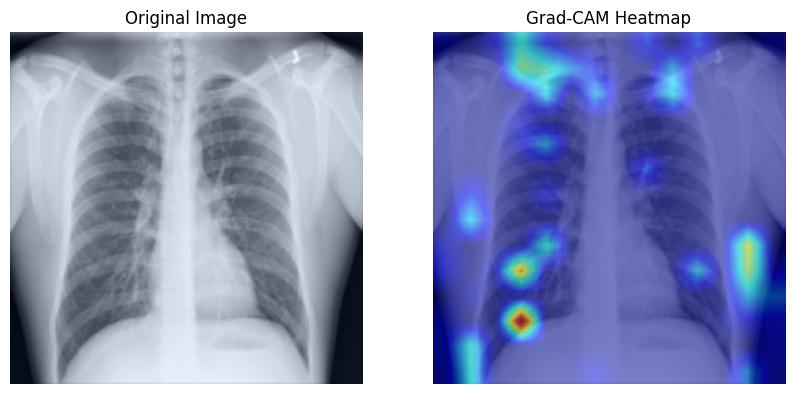

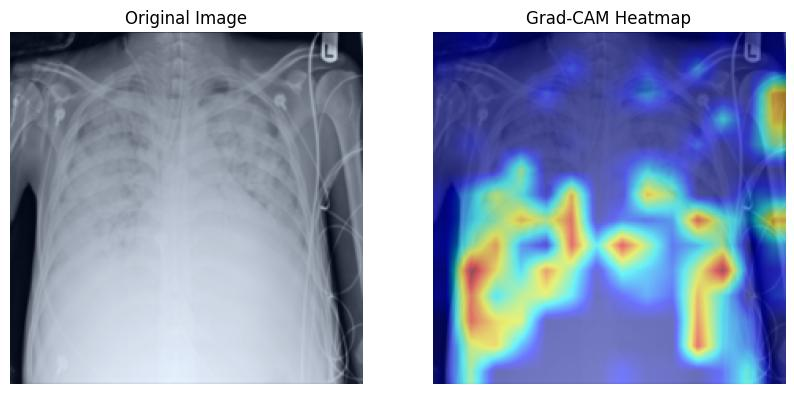

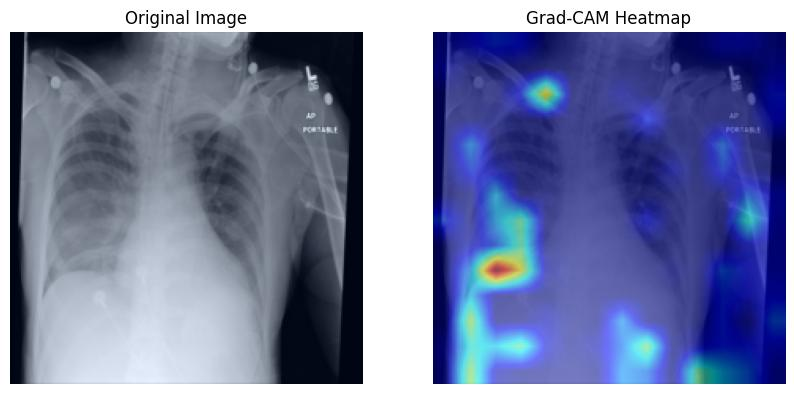

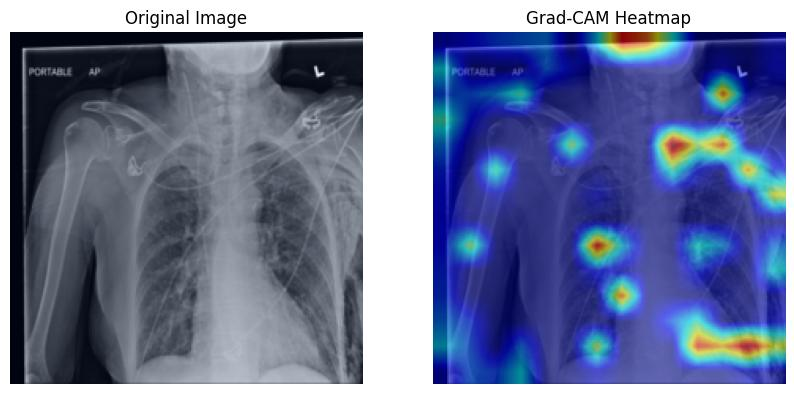

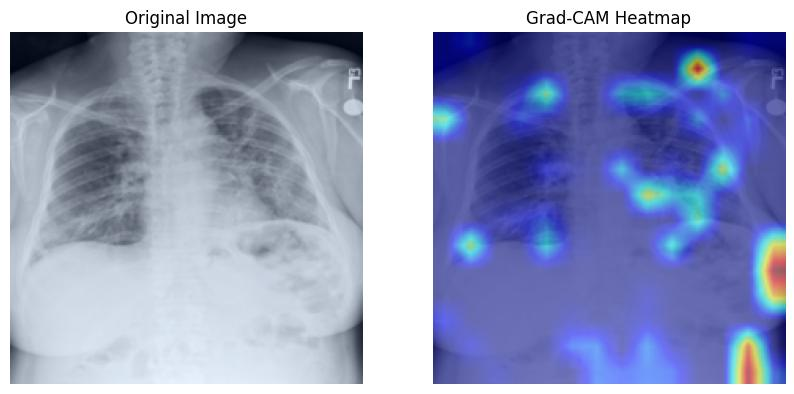

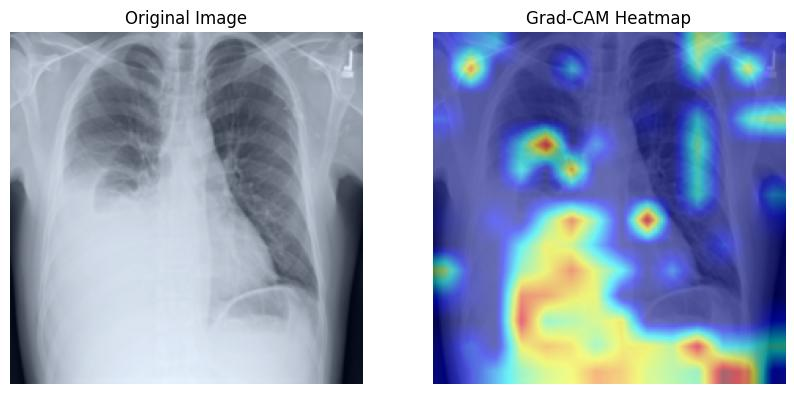

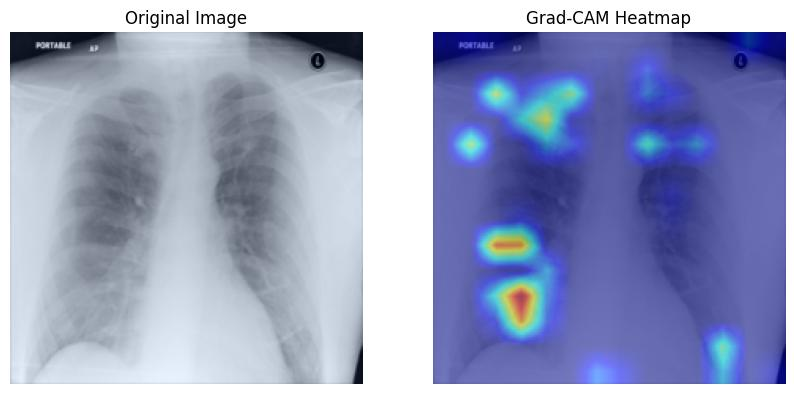

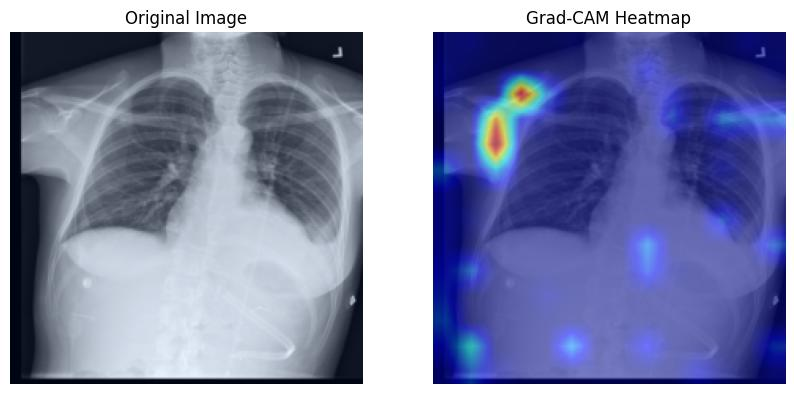

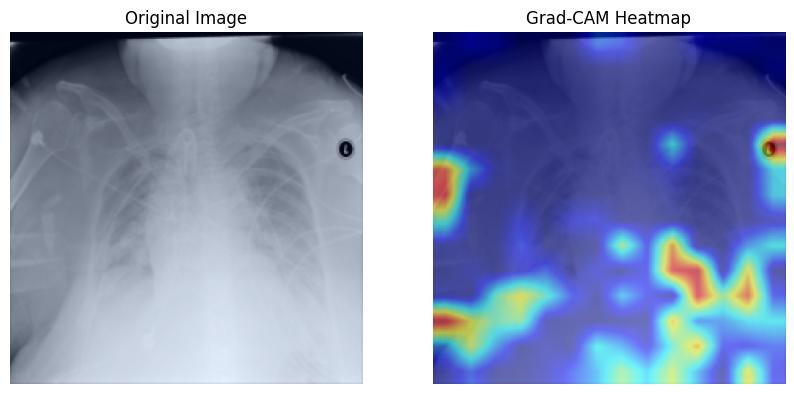

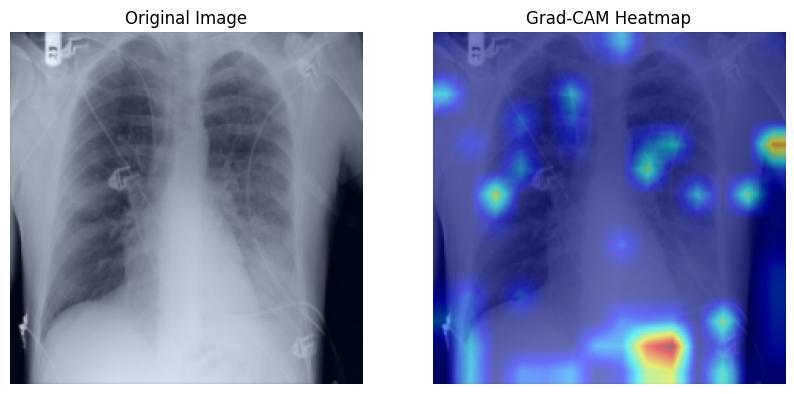

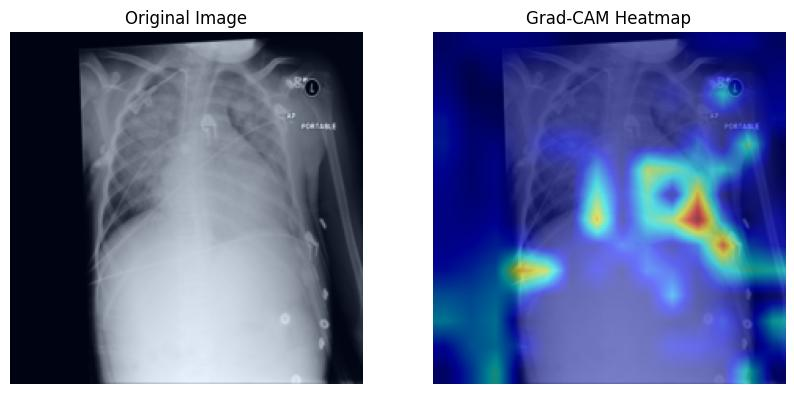

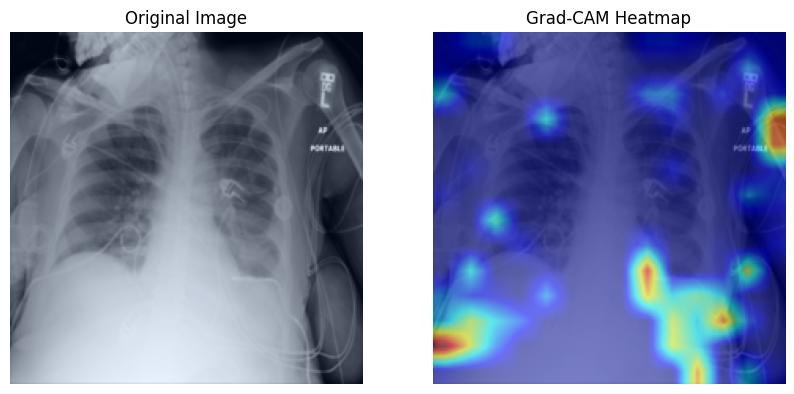

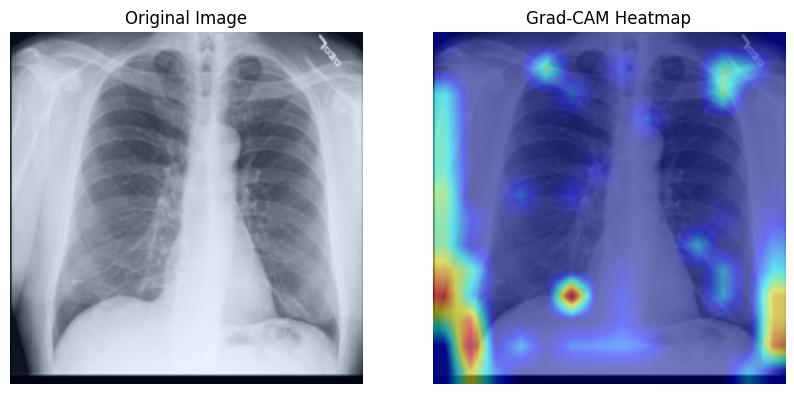

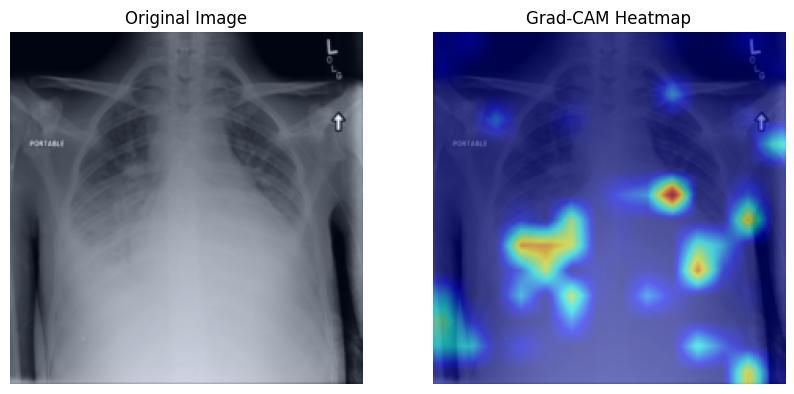

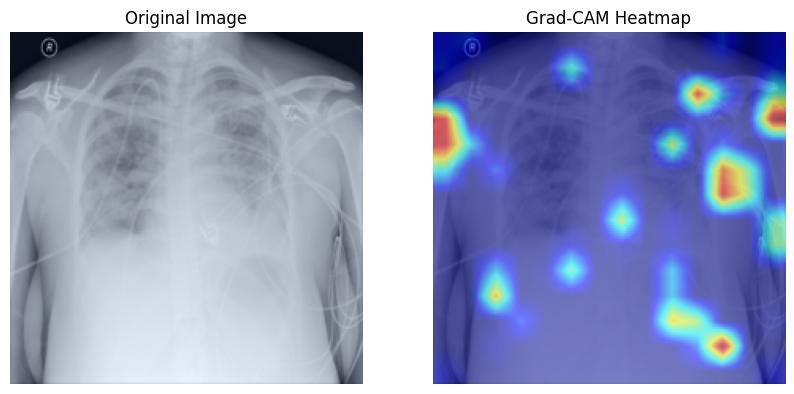

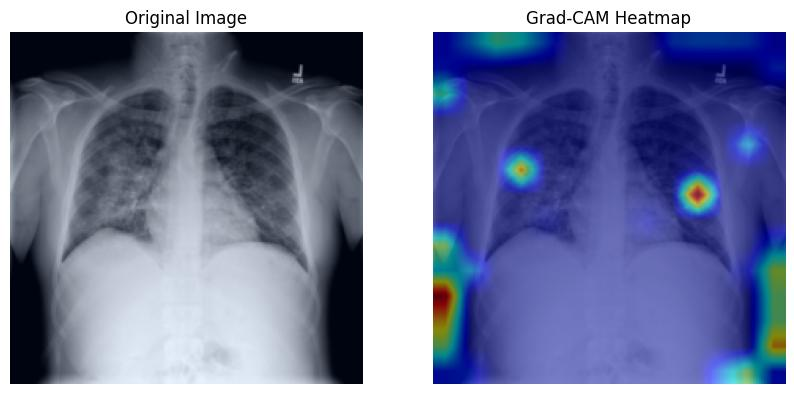

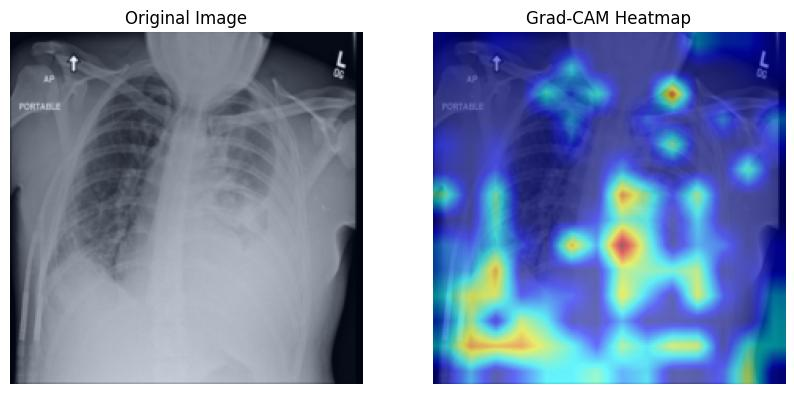

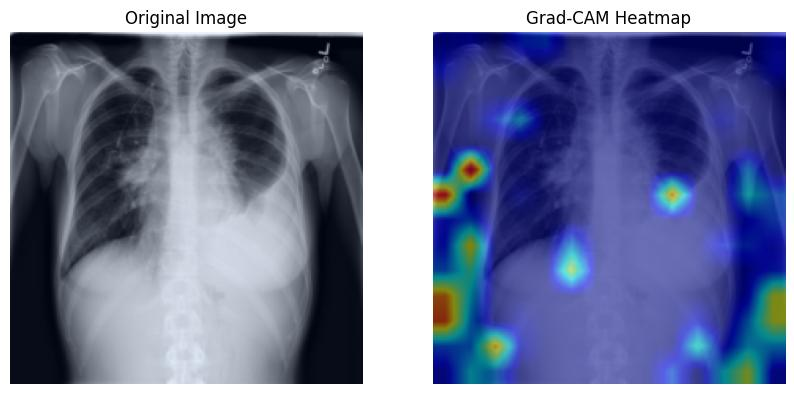

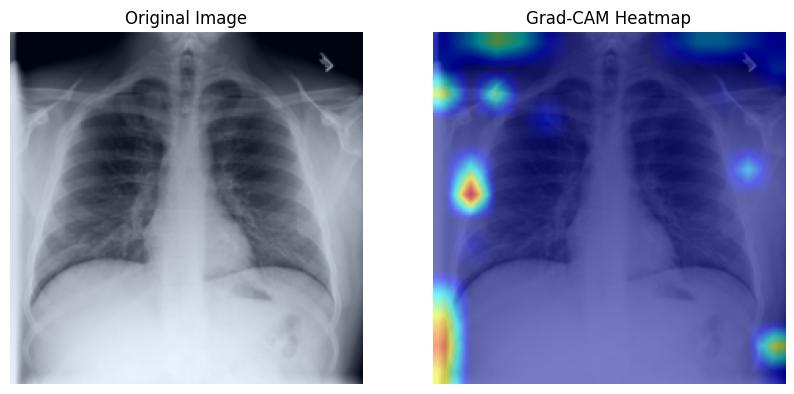

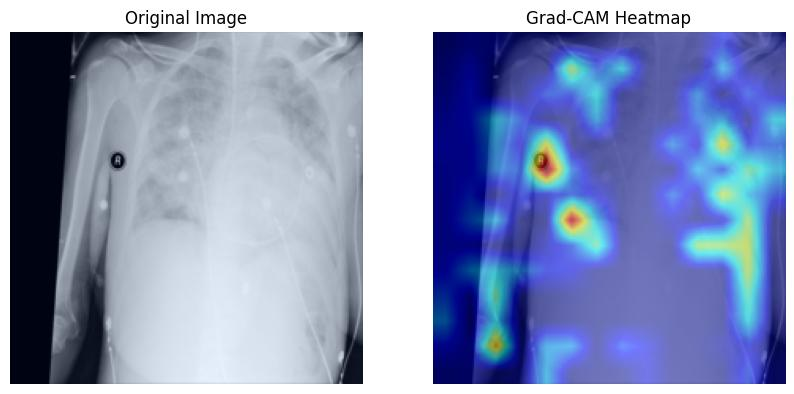

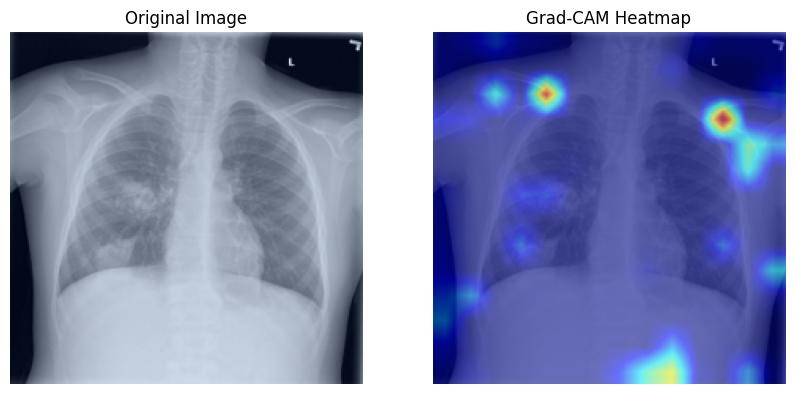

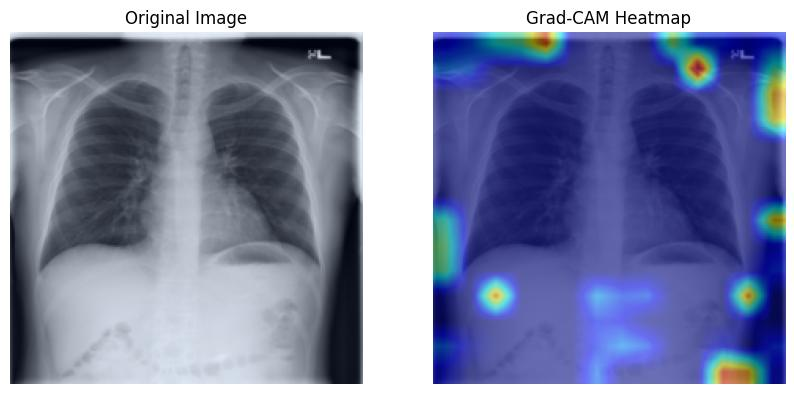

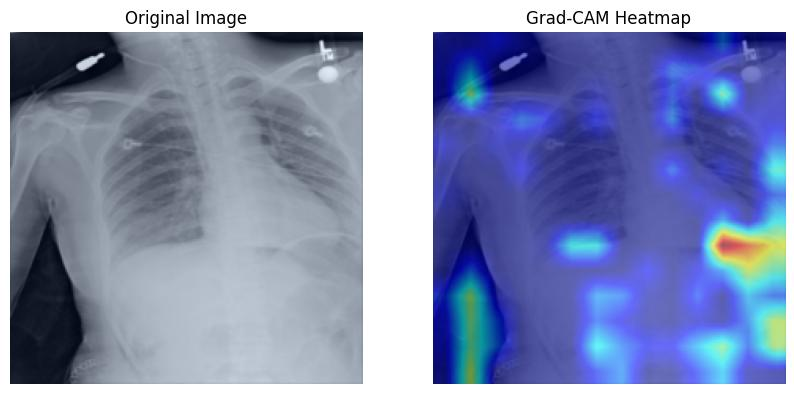

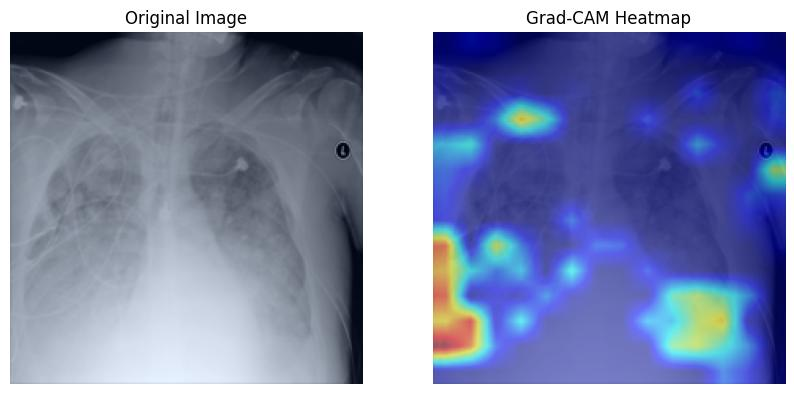

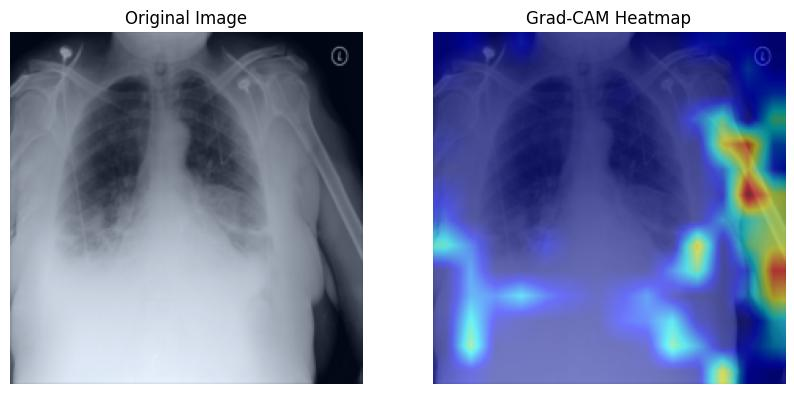

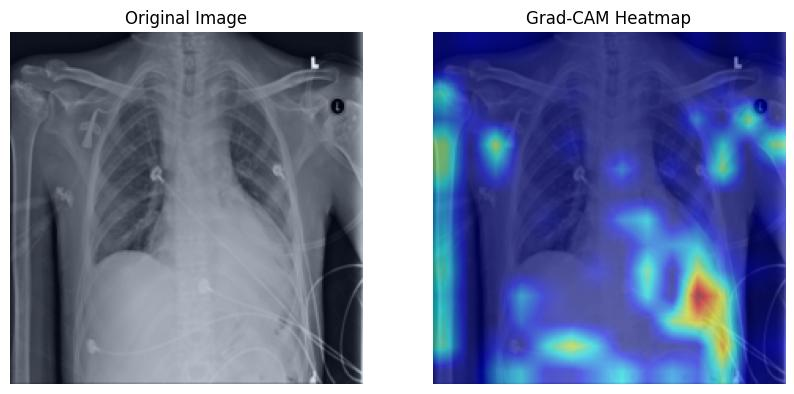

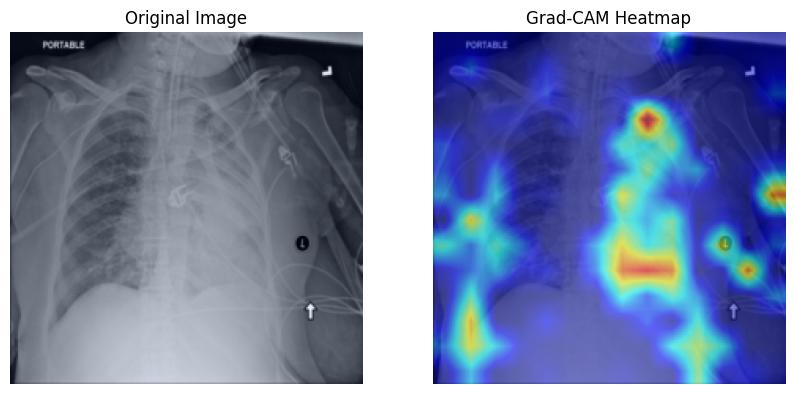

In [ ]:
# =======================
#  Imports
# =======================
import os
import math
import torch
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
import pandas as pd

# =======================
#  Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
NUM_SAMPLES = 30  # how many images to visualize

# =======================
#  Prepare sample files
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
#  Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# =======================
#  Grad-CAM wrapper
# =======================
class GradCAMWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        cls_out, _ = self.model(x)  # ignore localization output
        return cls_out  # raw logits for Grad-CAM

wrapped_model = GradCAMWrapper(model_loc).to(DEVICE)

# =======================
#  Initialize Grad-CAM
# =======================
cam = GradCAM(
    model=wrapped_model,
    target_layers=[model_loc.vit.blocks[-1].norm1],
    reshape_transform=lambda t: t[:,1:,:].reshape(
        t.size(0),
        int(math.sqrt(t.size(1)-1)),
        int(math.sqrt(t.size(1)-1)),
        t.size(2)
    ).permute(0,3,1,2)
)

# =======================
#  Run Grad-CAM on samples
# =======================
for sample_id in sample_files:
    img_path = os.path.join(IMAGE_DIR, sample_id + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)  # ensure Grad-CAM can track gradients

    # Grad-CAM
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0]  # predicted class automatically

    # normalize input image
    rgb_img = img_tensor.squeeze().permute(1,2,0).cpu().detach().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # overlay heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()


**Observations**:

Even after the localization supervision, the Grad-CAM heatmaps highlight largely the same regions as before. This occurs because the gradient-weighted backbone feature activations remain similar, and the localization head mainly redistrbutes attention intensity instead of shifting it to new regions. As a result, while the quantitative metrics such as Entropy and Sparsity changes, the heatmaps remain visually consistent.

## Insertion & Deletion Curves

**Concept**:

Insertion measures how the model's confidence rises as the important pixels are added back. Deletion measures how the model's confidence falls as those pixels are removed.

**Purpose**:

Used to evaluate the **faithfulness** of the explanations i.e. whether the highlighted regions truly influence the model's predictions or not.

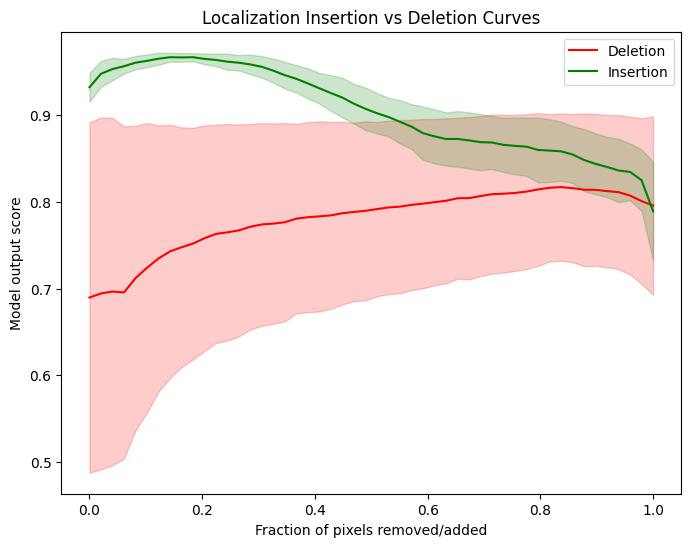

AUC Deletion: 0.7803, AUC Insertion: 0.9055


In [ ]:
# =======================
# 1️⃣ Imports
# =======================
import os
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# =======================
# 2️⃣ Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 50
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

# =======================
# 3️⃣ Grad-CAM for localization
# =======================
def reshape_loc(tensor, img_size=IMG_SIZE):
    B, N, C = tensor.size()  # N = num patches
    H = W = int(math.sqrt(N))
    result = tensor.permute(0, 2, 1).reshape(B, C, H, W)
    return result

# =======================
# 4️⃣ Transform & CSV
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 5️⃣ Blur baseline
# =======================
def blur_image_pil(img, radius=15):
    blurred = img.filter(ImageFilter.GaussianBlur(radius=radius))
    img_np = np.array(blurred)/255.0
    tensor = torch.tensor(img_np.transpose(2,0,1), dtype=torch.float32)
    return tensor.unsqueeze(0).to(DEVICE)

# =======================
# 6️⃣ Insertion/Deletion curves
# =======================
del_curves = []
ins_curves = []

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Forward pass ----------
    with torch.no_grad():
        cls_out, loc_out = model_loc(img_tensor)  # loc_out: (B,1,H,W)
        pred_score = cls_out.item()

    # ---------- Heatmap ----------
    attr = loc_out.squeeze(0).squeeze(0).cpu().numpy()  # (H,W)
    attr = attr / (attr.max() + 1e-8)                   # normalize 0-1

    flat_attr = attr.flatten()
    sort_idx = np.argsort(flat_attr)[::-1]  # top importance first

    # ---------- Deletion ----------
    del_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    scores = []
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = del_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = 0
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores.append(score)
    del_curves.append(scores)

    # ---------- Insertion ----------
    ins_img = np.zeros_like(del_img)
    scores = []
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = ins_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = del_img.flatten()[sort_idx[:num_pixels]]
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores.append(score)
    ins_curves.append(scores)

# =======================
# 7️⃣ Average & plot
# =======================
del_mean = np.mean(del_curves, axis=0)
del_std = np.std(del_curves, axis=0)
ins_mean = np.mean(ins_curves, axis=0)
ins_std = np.std(ins_curves, axis=0)

x = np.linspace(0,1,STEPS)

plt.figure(figsize=(8,6))
plt.plot(x, del_mean, label='Deletion', color='red')
plt.fill_between(x, del_mean-del_std, del_mean+del_std, color='red', alpha=0.2)
plt.plot(x, ins_mean, label='Insertion', color='green')
plt.fill_between(x, ins_mean-ins_std, ins_mean+ins_std, color='green', alpha=0.2)
plt.xlabel("Fraction of pixels removed/added")
plt.ylabel("Model output score")
plt.title("Localization Insertion vs Deletion Curves")
plt.legend()
plt.show()

# =======================
# 8️⃣ Compute AUC
# =======================
from sklearn.metrics import auc
auc_del = auc(x, del_mean)
auc_ins = auc(x, ins_mean)
print(f"AUC Deletion: {auc_del:.4f}, AUC Insertion: {auc_ins:.4f}")


**Observations**:

Although Grad-CAM heatmaps highlight largely the same regions before and after localization, the Insertion and Deletion curves become less intuitive post-localization. This occurs because, after localization, the model has re-learned more meaningful features within the lung regions, so adding the pixels highlighted by Grad-CAM can sometimes confuse the model rather than increasing its confidence.

## Entropy & Sparsity
**Concept**:

Entropy measures how spread-out the attention is on a saliency map, while Sparsity quantifies how concentrated it is (i.e. how much of the total area actually carries **meaningful activation**)

For highly focused attributions, the Entropy should be lower while the Sparsity should be higher.


**Purpose**:

Used to quantify how focused or diffused the model's visual explanations are across all the classes.

In [ ]:
# =======================
# 1️⃣ Helper functions
# =======================
def heatmap_entropy(hmap):
    """
    Compute normalized Shannon entropy of a heatmap.
    hmap: 2D numpy array, values 0-1
    """
    hmap_flat = hmap.flatten()
    hmap_flat = hmap_flat / (hmap_flat.sum() + 1e-8)  # normalize to sum=1
    hmap_flat = np.clip(hmap_flat, 1e-12, 1)          # avoid log(0)
    return -np.sum(hmap_flat * np.log2(hmap_flat))

def heatmap_sparsity(hmap, threshold=0.5):
    """
    Fraction of pixels below threshold -> how sparse the heatmap is.
    threshold: float, pixels < threshold considered zero
    """
    return np.sum(hmap < threshold) / hmap.size

# =======================
# 2️⃣ Compute entropy & sparsity for all samples
# =======================
entropies = []
sparsities = []

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        _, loc_out = model_loc(img_tensor)

    heatmap = loc_out.squeeze(0).squeeze(0).cpu().numpy()
    heatmap = heatmap / (heatmap.max() + 1e-8)  # normalize 0-1

    ent = heatmap_entropy(heatmap)
    spr = heatmap_sparsity(heatmap, threshold=0.5)

    entropies.append(ent)
    sparsities.append(spr)

# =======================
# 3️⃣ Summary statistics
# =======================
print(f"Mean entropy: {np.mean(entropies):.4f}, Std: {np.std(entropies):.4f}")
print(f"Mean sparsity: {np.mean(sparsities):.4f}, Std: {np.std(sparsities):.4f}")


Mean entropy: 14.4395, Std: 0.1973
Mean sparsity: 0.9937, Std: 0.0024


**Observations**:

The increase in Entropy and Sparsity after localization suggests that the localization head has refined the attention, making it more focused (high Sparsity) but with slightly more intensity variation (higher Entropy). The quantitative metrics detect the internal redistrbution of attention intensity.

## Grad-CAM++: Visualizing model attention

**Concept**:

Grad-CAM++ refines Grad-CAM by incorporating higher-order gradient information. This enhances localization and handling of multiple object instances.

**Purpose**:

Used to asses how finely the model distinguishes multiple features or parts within an image.

**Quick references**:

Chattopadhyay et al., Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks, WACV 2018.

Gildenblat, pytorch-grad-cam library — robust reference implementation.

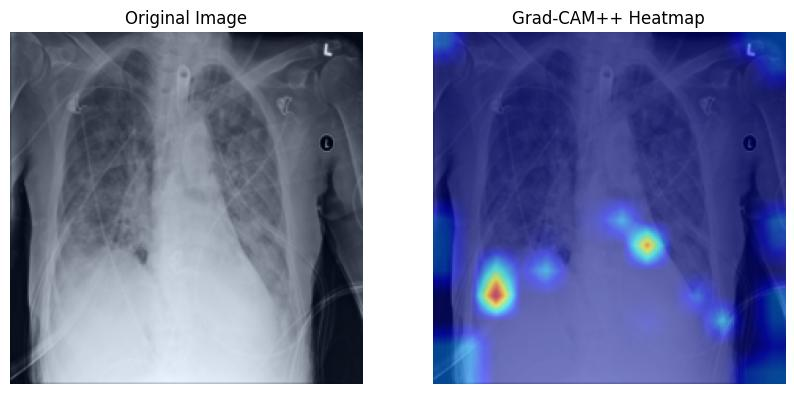

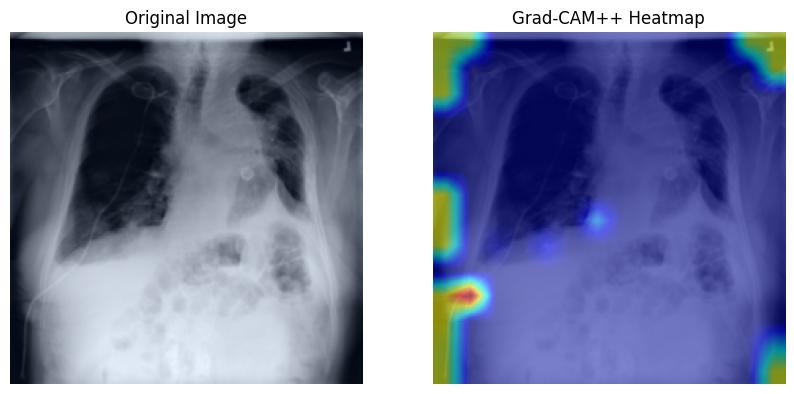

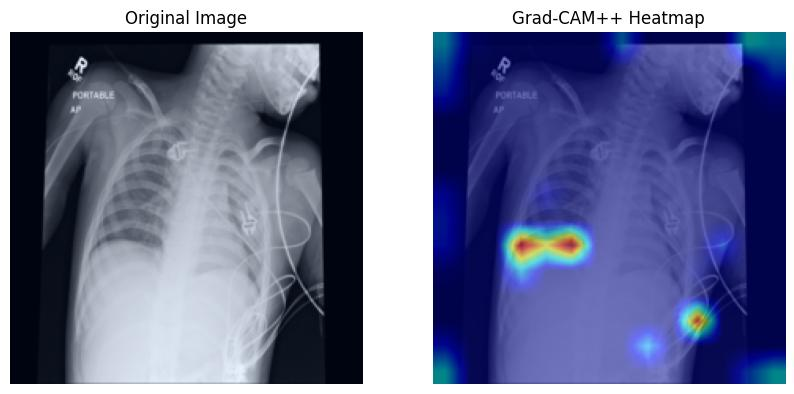

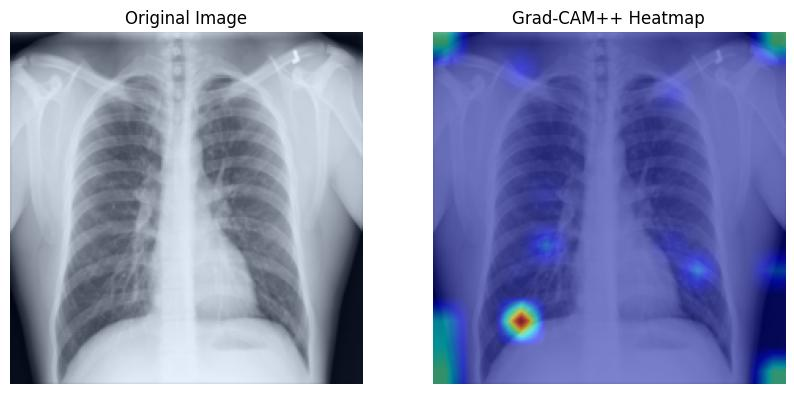

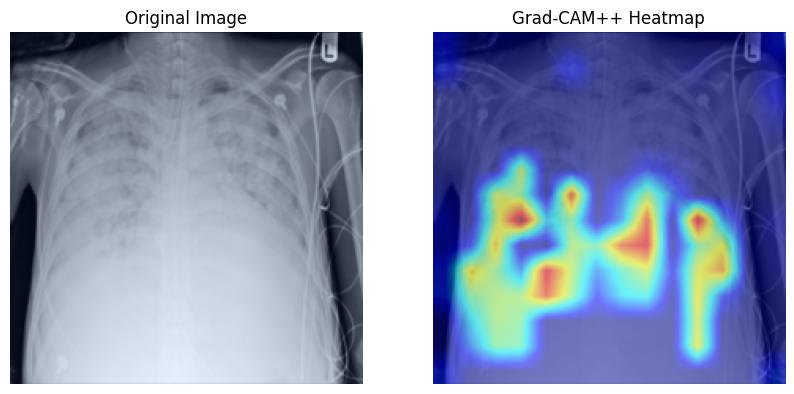

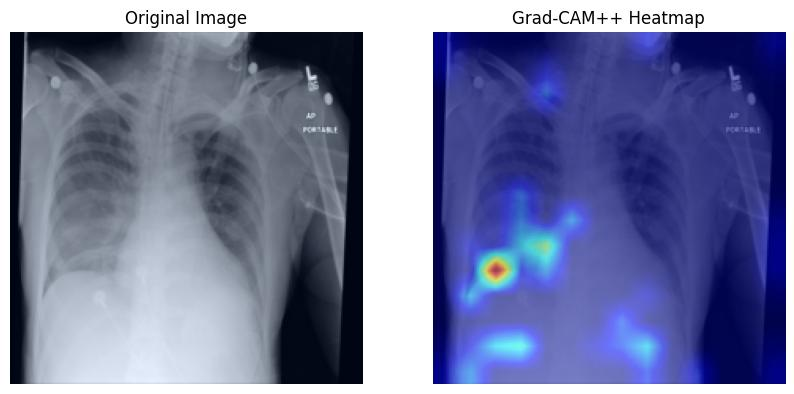

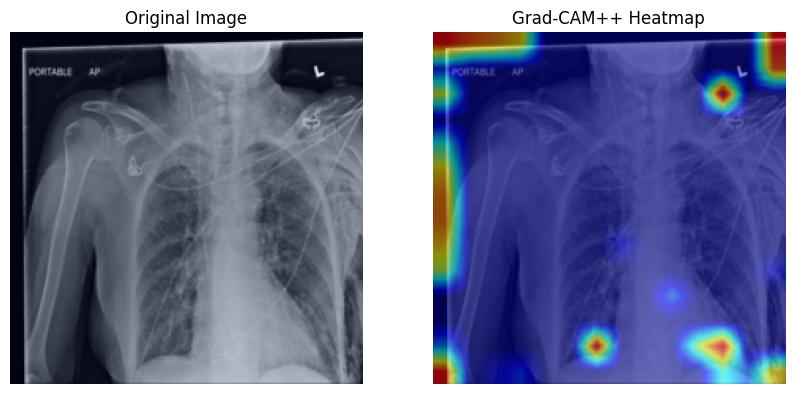

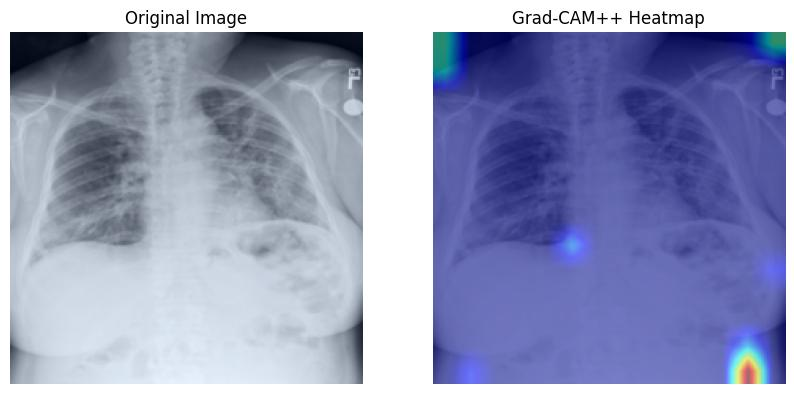

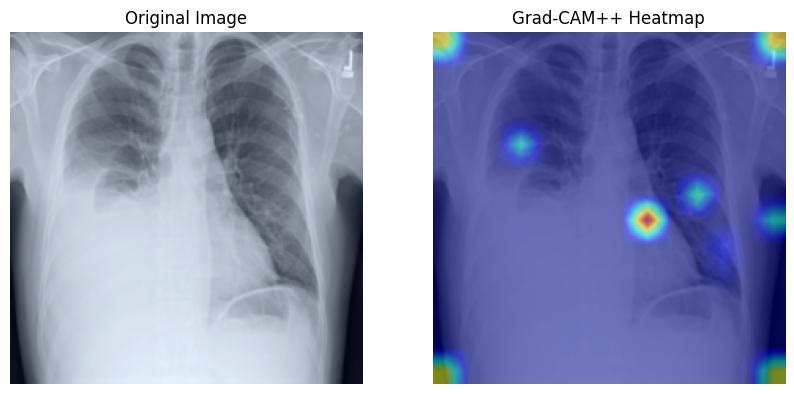

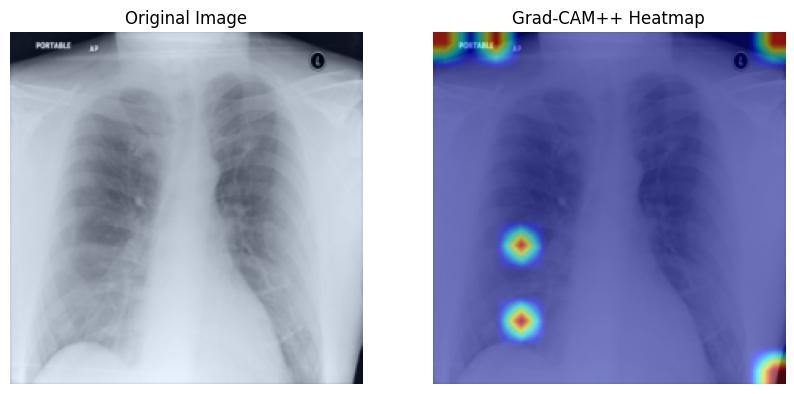

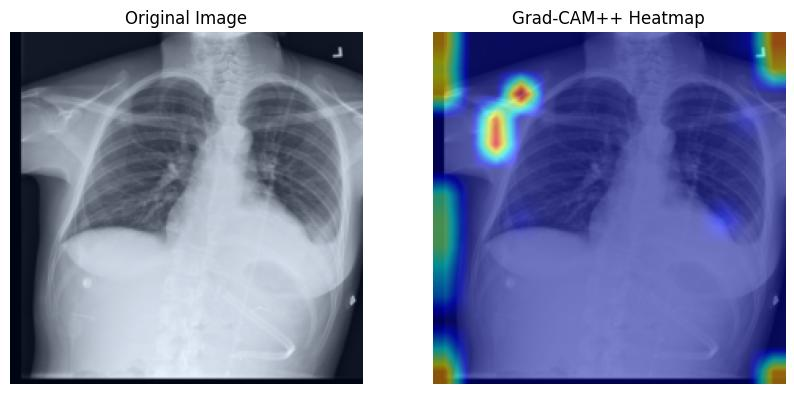

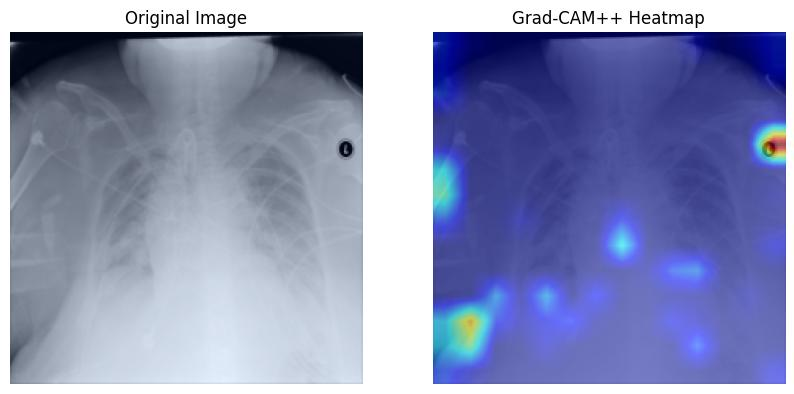

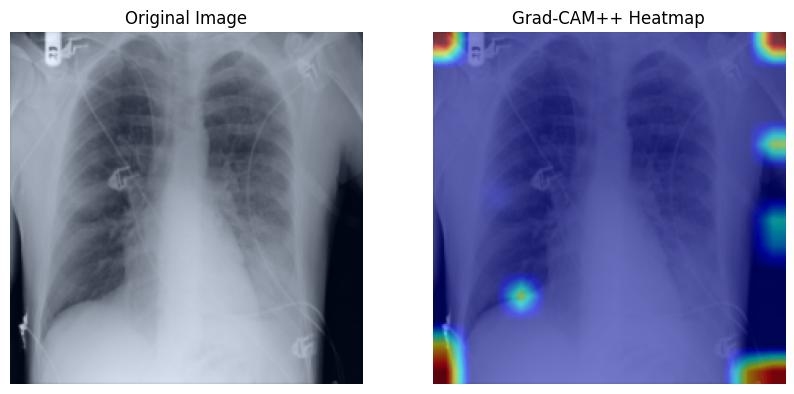

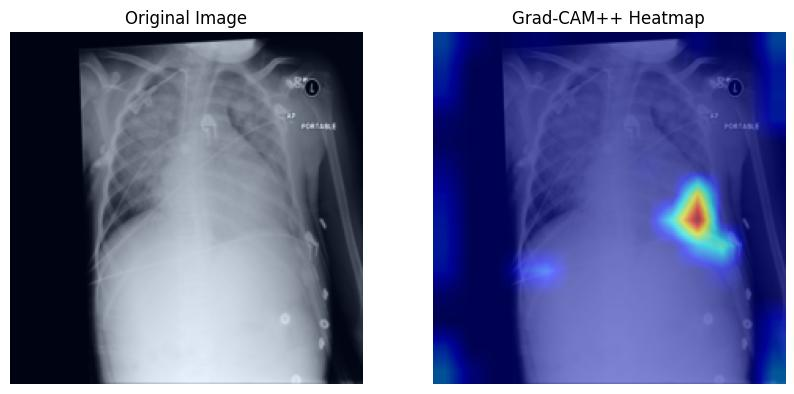

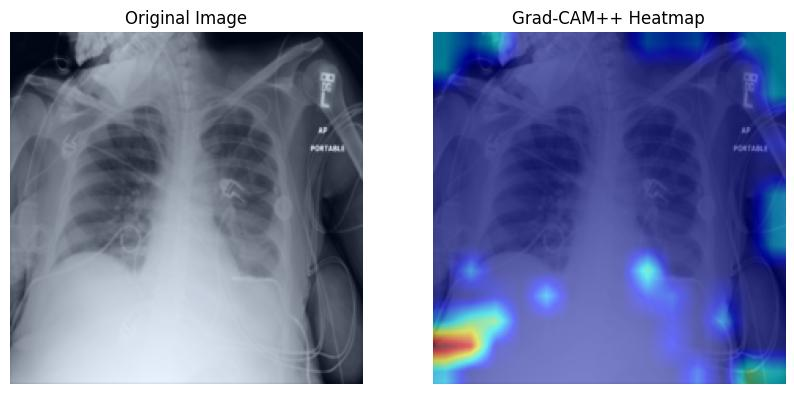

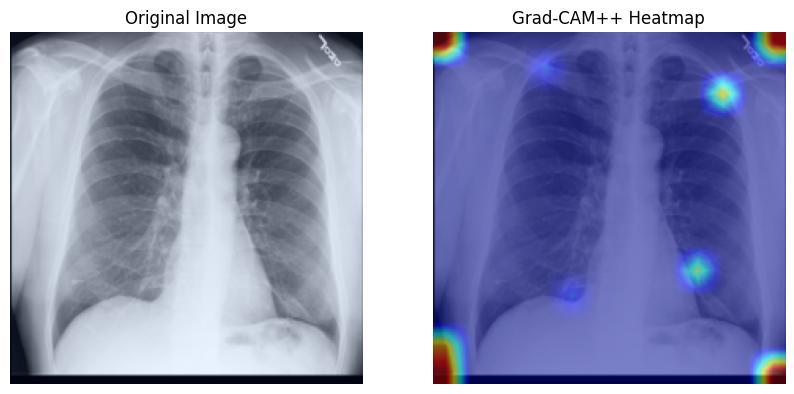

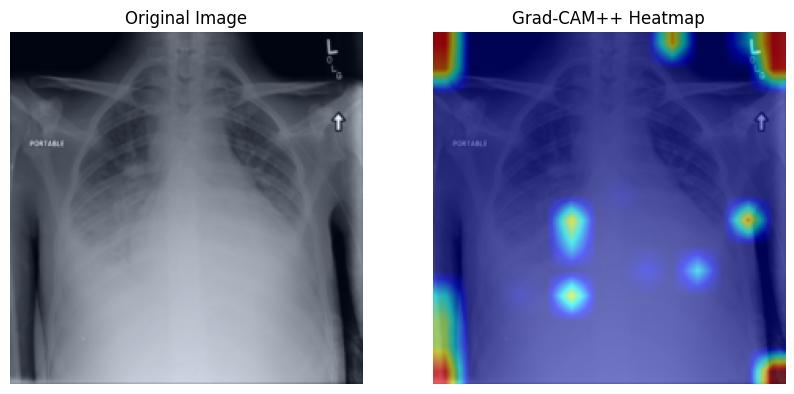

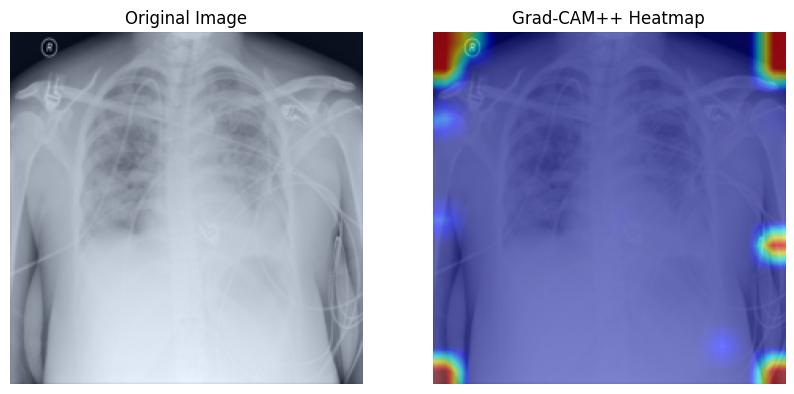

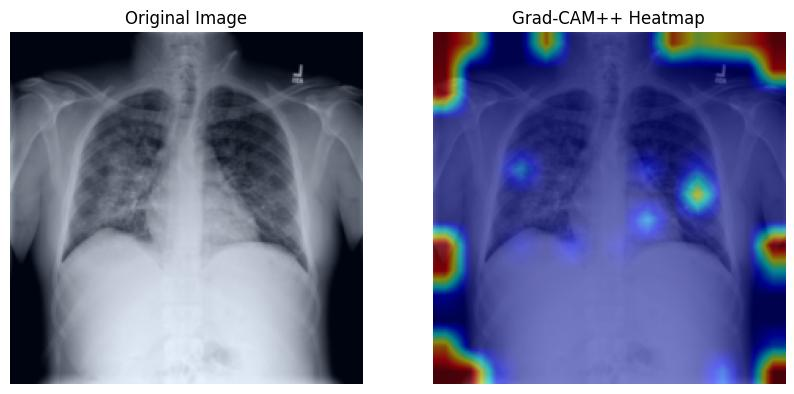

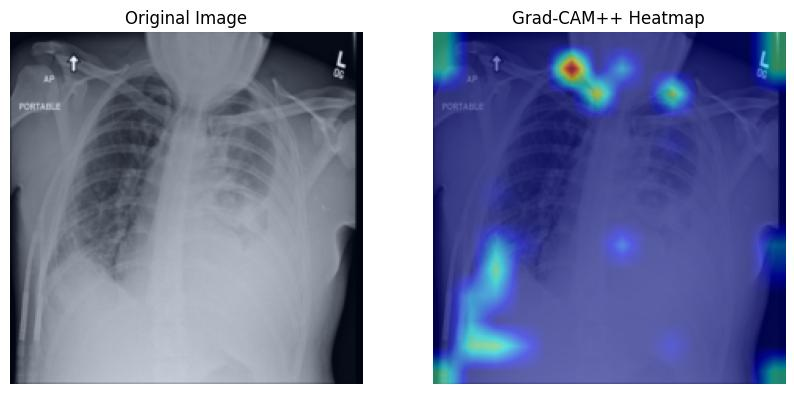

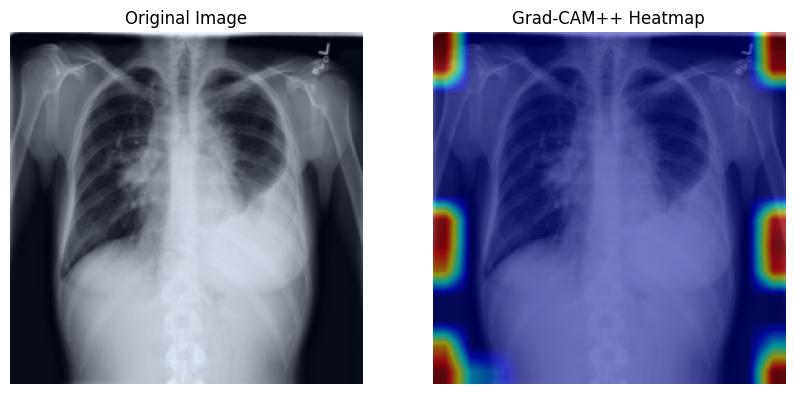

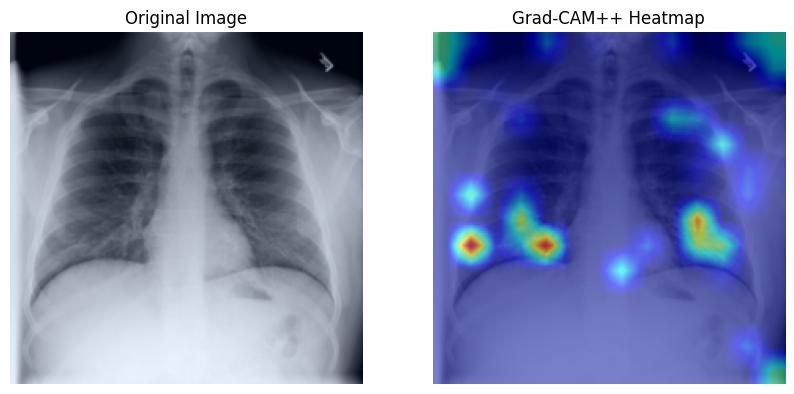

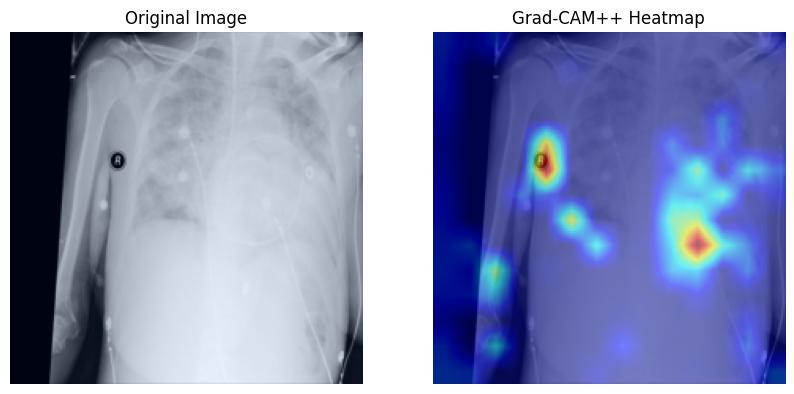

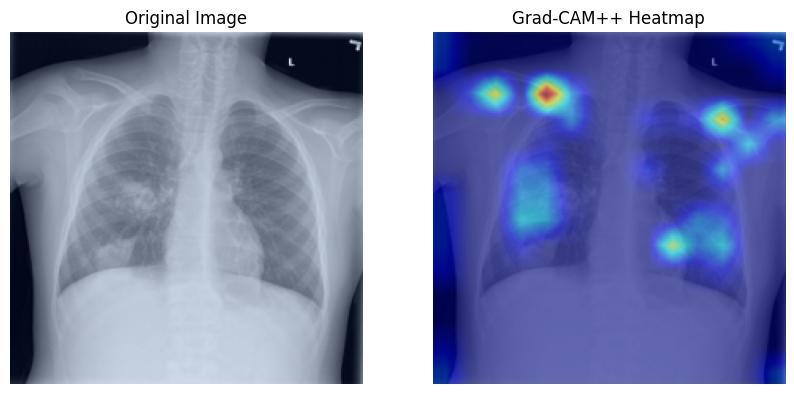

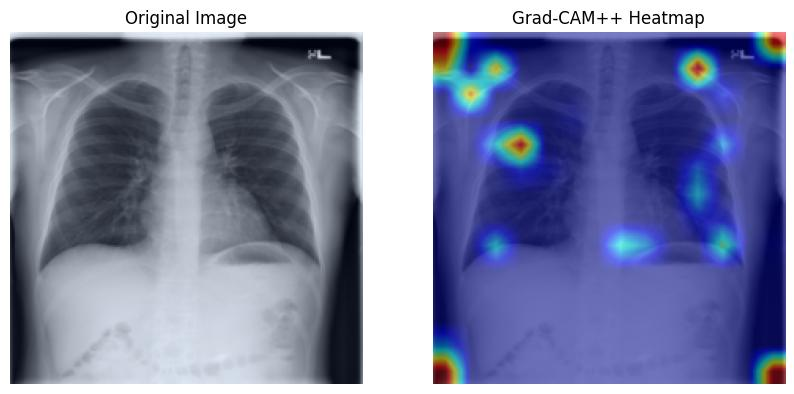

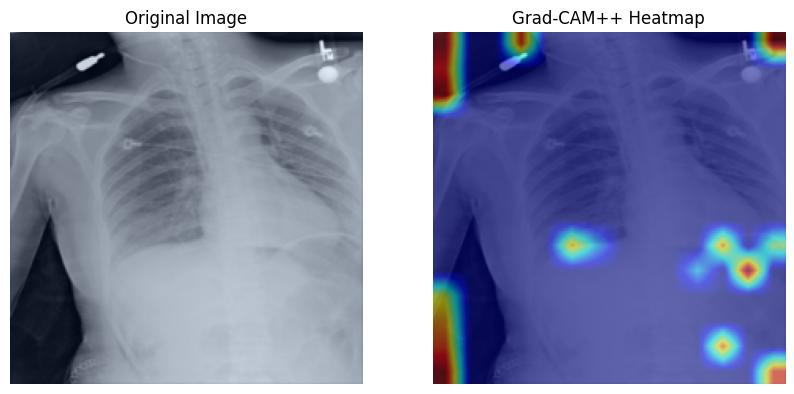

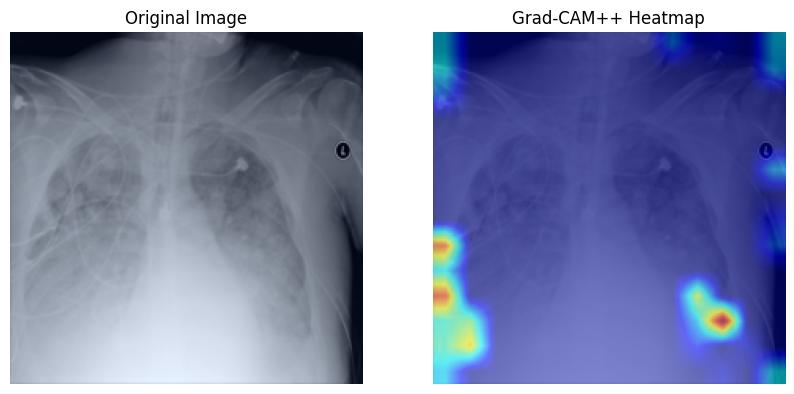

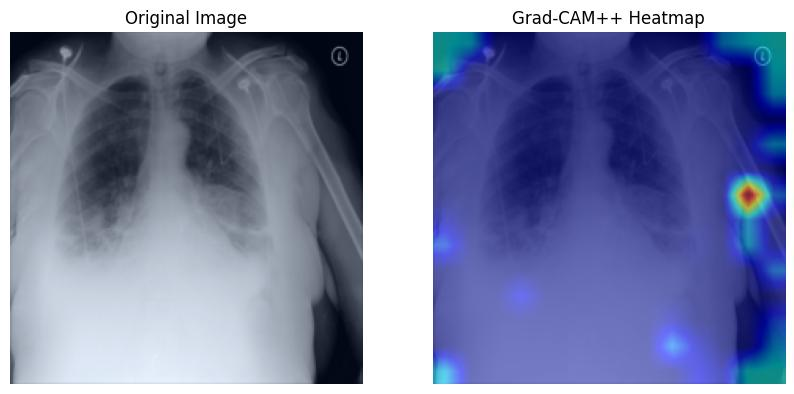

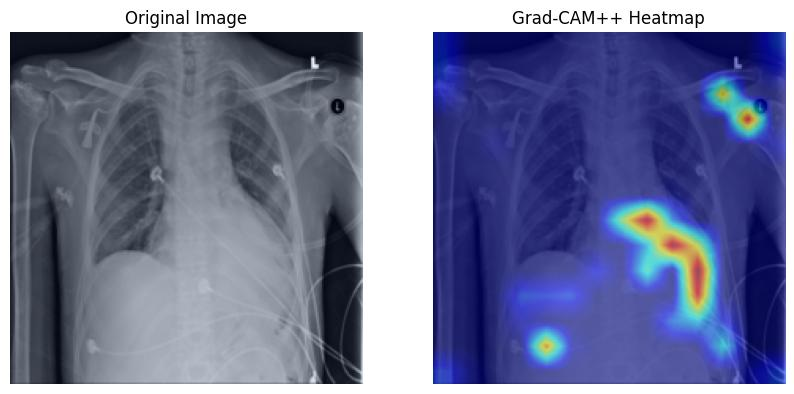

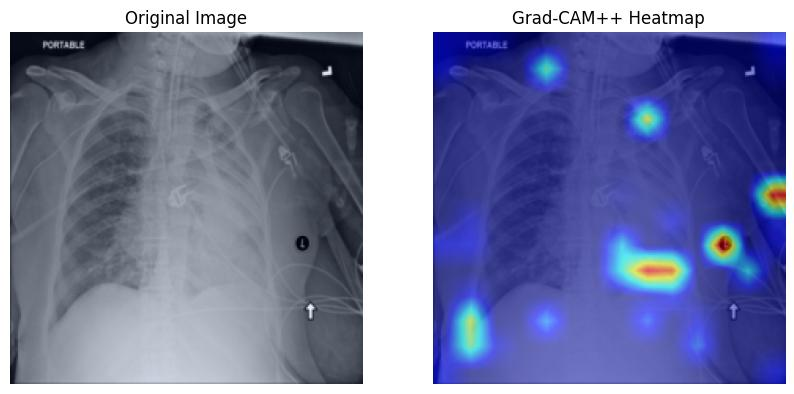

In [ ]:
# =======================
# 1️⃣ Imports
# =======================
import os
import math
import torch
import torch.nn as nn
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
import pandas as pd

# =======================
# 2️⃣ Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
NUM_SAMPLES = 30  # how many images to visualize

# =======================
# 3️⃣ Prepare sample files
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 4️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# =======================
# 5️⃣ Grad-CAM wrapper
# =======================
class GradCAMWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        cls_out, _ = self.model(x)  # ignore localization output
        return cls_out  # raw logits for Grad-CAM

wrapped_model = GradCAMWrapper(model_loc).to(DEVICE)

# =======================
# 6️⃣ Initialize Grad-CAM
# =======================
cam = GradCAMPlusPlus(
    model=wrapped_model,
    target_layers=[model_loc.vit.blocks[-1].norm1],
    reshape_transform=lambda t: t[:,1:,:].reshape(
        t.size(0),
        int(math.sqrt(t.size(1)-1)),
        int(math.sqrt(t.size(1)-1)),
        t.size(2)
    ).permute(0,3,1,2)
)

# =======================
# 7️⃣ Run Grad-CAM on samples
# =======================
for sample_id in sample_files:
    img_path = os.path.join(IMAGE_DIR, sample_id + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)  # ensure Grad-CAM can track gradients

    # Grad-CAM
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0]  # predicted class automatically

    # normalize input image
    rgb_img = img_tensor.squeeze().permute(1,2,0).cpu().detach().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # overlay heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rgb_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(visualization)
    plt.title("Grad-CAM++ Heatmap")
    plt.axis('off')
    plt.show()


**Observations**:

Grad-CAM++ heatmaps, like Grad-CAM, continue to highlight the same region before and after localization, indicating that the attention head has only redsitrbuted the attention and hasn't shifted the attention to new regions. 

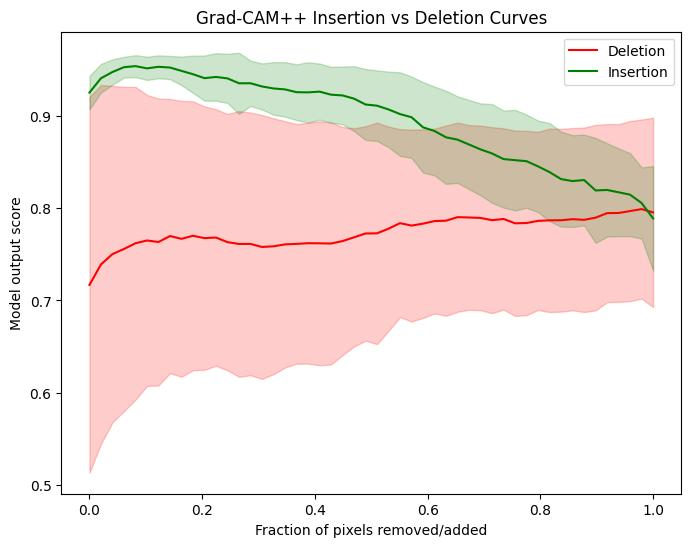

AUC Deletion: 0.7744, AUC Insertion: 0.8958


In [ ]:
# =======================
# 1️⃣ Imports (if not already)
# =======================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from PIL import Image
import os

# =======================
# 2️⃣ Config
# =======================
STEPS = 50  # number of steps for insertion/deletion
NUM_SAMPLES = len(sample_files)
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'

del_curves = []
ins_curves = []

# =======================
# 3️⃣ Insertion / Deletion curves
# =======================
for sample_id in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{sample_id}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)

    # ---------- Grad-CAM++ heatmap ----------
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0]  # predicted class
    heatmap = grayscale_cam / (grayscale_cam.max() + 1e-8)  # normalize 0-1

    flat_attr = heatmap.flatten()
    sort_idx = np.argsort(flat_attr)[::-1]  # most important pixels first

    del_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    scores_del = []
    scores_ins = []

    # ---------- Deletion ----------
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = del_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = 0
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores_del.append(score)

    # ---------- Insertion ----------
    ins_img = np.zeros_like(del_img)
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = ins_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = del_img.flatten()[sort_idx[:num_pixels]]
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores_ins.append(score)

    del_curves.append(scores_del)
    ins_curves.append(scores_ins)

# =======================
# 4️⃣ Average & plot
# =======================
del_mean = np.mean(del_curves, axis=0)
del_std = np.std(del_curves, axis=0)
ins_mean = np.mean(ins_curves, axis=0)
ins_std = np.std(ins_curves, axis=0)

x = np.linspace(0,1,STEPS)

plt.figure(figsize=(8,6))
plt.plot(x, del_mean, label='Deletion', color='red')
plt.fill_between(x, del_mean-del_std, del_mean+del_std, color='red', alpha=0.2)
plt.plot(x, ins_mean, label='Insertion', color='green')
plt.fill_between(x, ins_mean-ins_std, ins_mean+ins_std, color='green', alpha=0.2)
plt.xlabel("Fraction of pixels removed/added")
plt.ylabel("Model output score")
plt.title("Grad-CAM++ Insertion vs Deletion Curves")
plt.legend()
plt.show()

# =======================
# 5️⃣ Compute AUC
# =======================
auc_del = auc(x, del_mean)
auc_ins = auc(x, ins_mean)
print(f"AUC Deletion: {auc_del:.4f}, AUC Insertion: {auc_ins:.4f}")


**Observations**:

The Insertion and Deletion curves also follow a comparable trend, indicating that the redistribution of attention intensity within the highlighted regions affect the model predictions in a manner consistent with Grad-CAM.

In [ ]:
# =======================
# 0️⃣ Import for entropy
# =======================
from scipy.stats import entropy

# =======================
# 1️⃣ Prepare lists to store metrics
# =======================
heatmap_entropies = []
heatmap_sparsities = []

# =======================
# 2️⃣ Loop through samples
# =======================
for sample_id in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{sample_id}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)

    # ---------- Grad-CAM++ heatmap ----------
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0]  # predicted class
    heatmap = grayscale_cam / (grayscale_cam.max() + 1e-8)  # normalize 0-1

    # ---------- Entropy ----------
    # flatten heatmap and convert to probability distribution
    flat_heatmap = heatmap.flatten()
    prob_dist = flat_heatmap / (flat_heatmap.sum() + 1e-8)
    ent = entropy(prob_dist)  # Shannon entropy
    heatmap_entropies.append(ent)

    # ---------- Sparsity ----------
    sparsity = np.sum(flat_heatmap < 0.01) / flat_heatmap.size  # fraction near-zero pixels
    heatmap_sparsities.append(sparsity)

# =======================
# average metrics
# =======================
avg_entropy = np.mean(heatmap_entropies)
avg_sparsity = np.mean(heatmap_sparsities)
print(f"Average Entropy: {avg_entropy:.4f}, Average Sparsity: {avg_sparsity:.4f}")


Average Entropy: 9.0065, Average Sparsity: 0.7306


**Observations**:

Grad-CAM++ heatmaps have a moderately high Sparsity and lower Entropy compared to Grad-CAM, indicating that the model's attention is more concentrated, but still covering a broad area.

## Integrated Gradients: Visualizing model attention

**Concepts:**

Integrated Gradients captures pixel-wise contribution by accumulating gradients along a path from a baseline (usually a zero image) to the actual input.

**Purpose:**

Used to quantify pixel-level contrbution, providing a fine-grained understanding of sensitivity.

**Quick references:**

Sundararajan et al., Axiomatic Attribution for Deep Networks (ICML 2017).

Captum (PyTorch) — Official interpretability library used for the IG implementation.

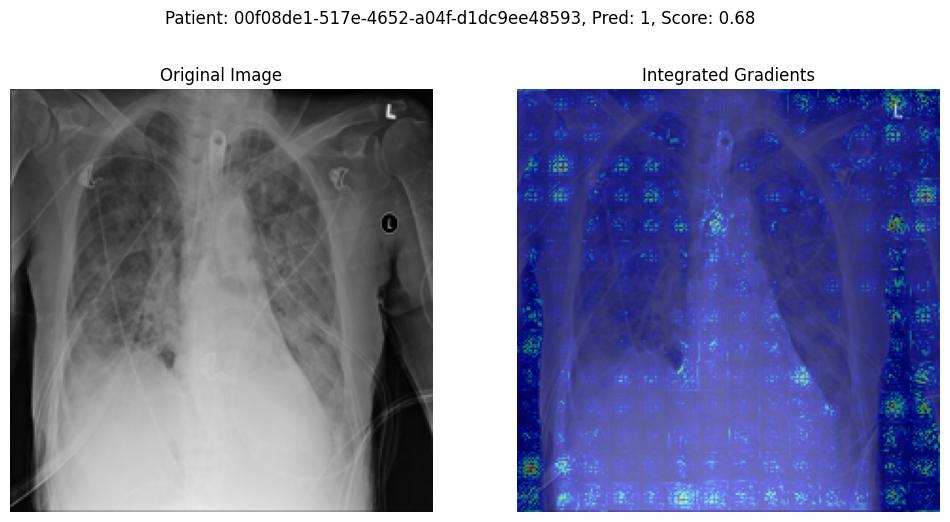

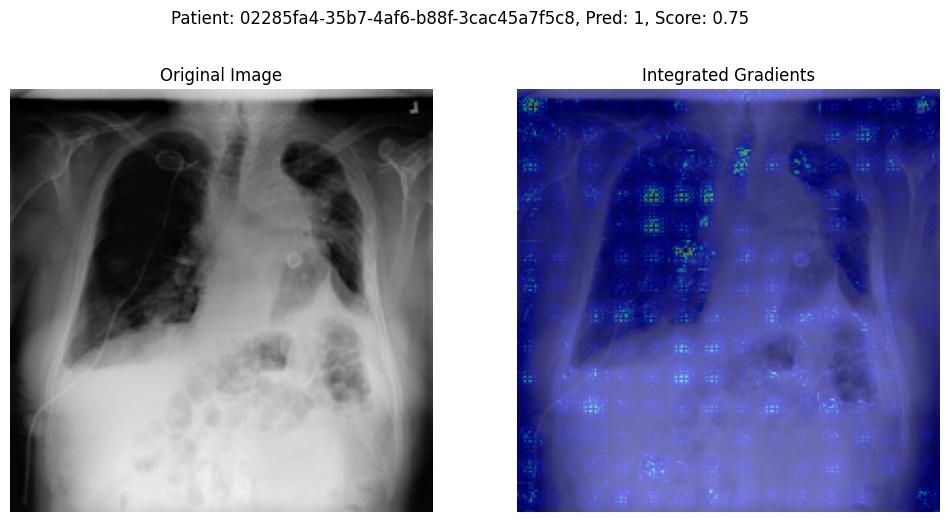

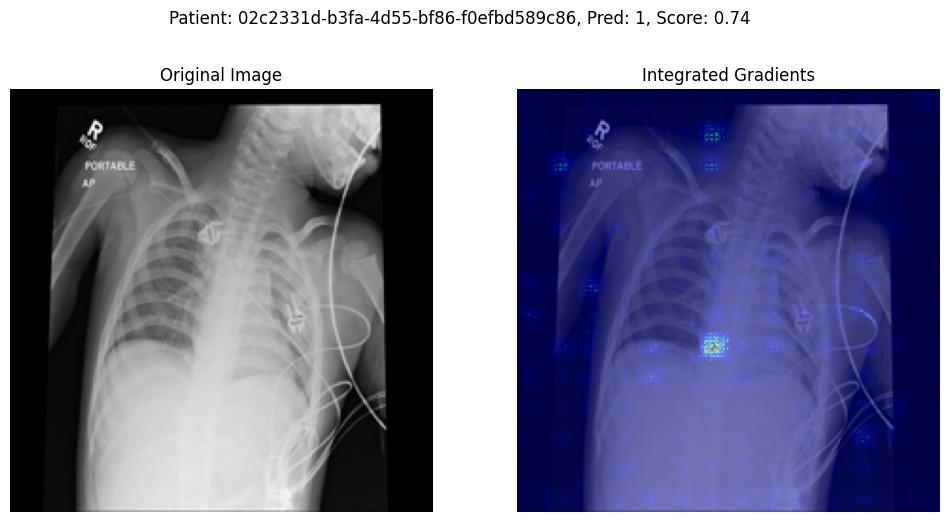

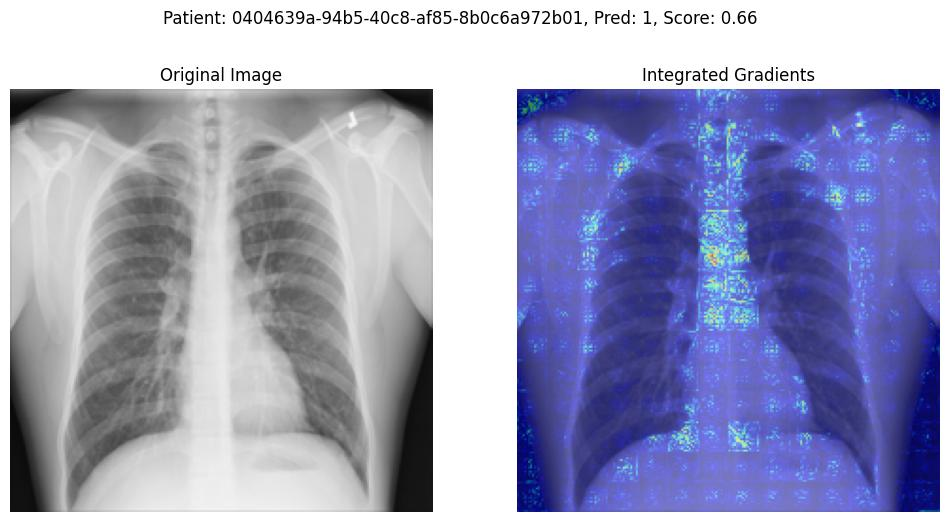

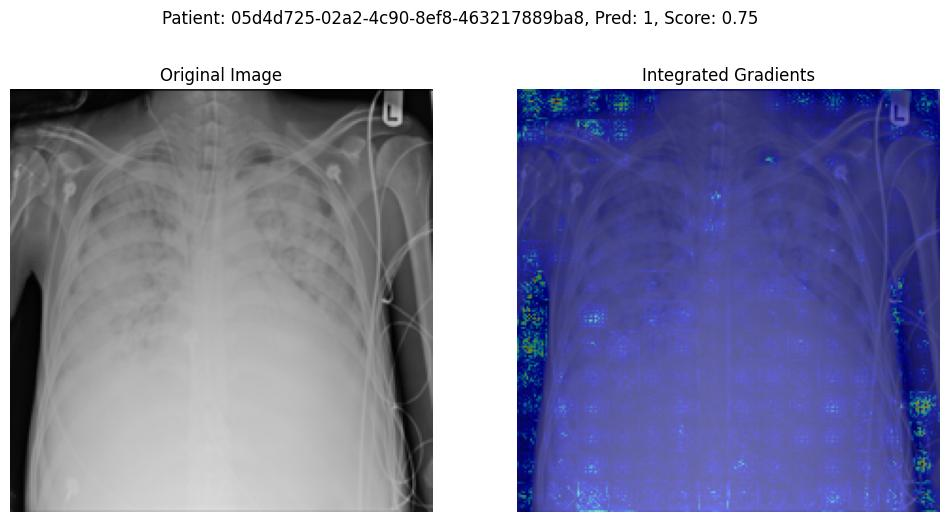

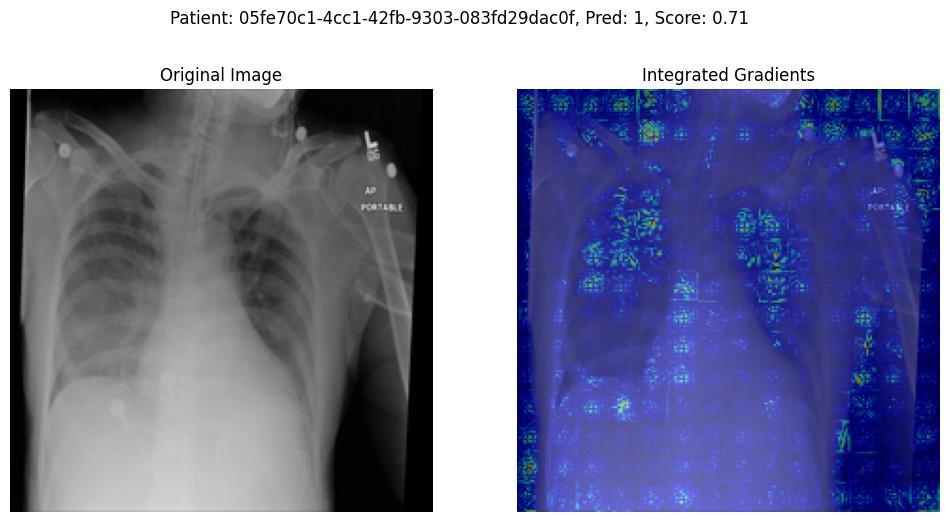

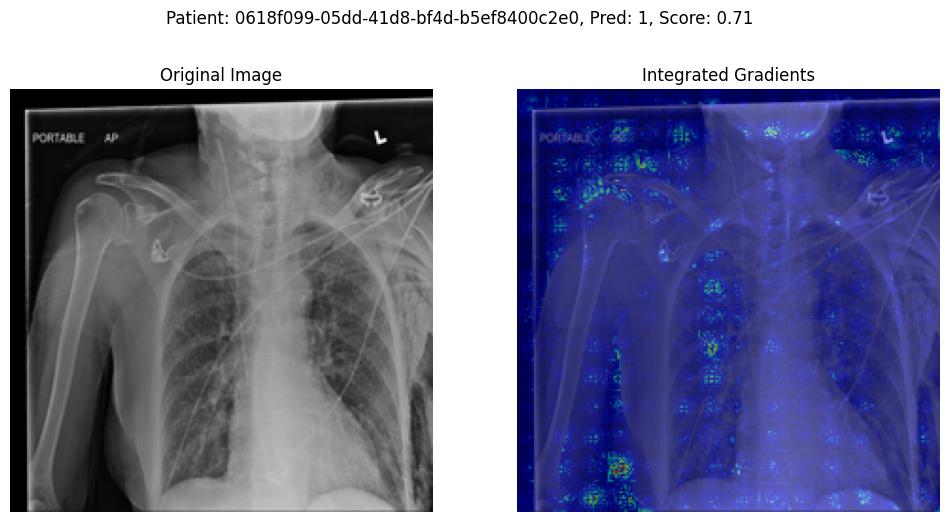

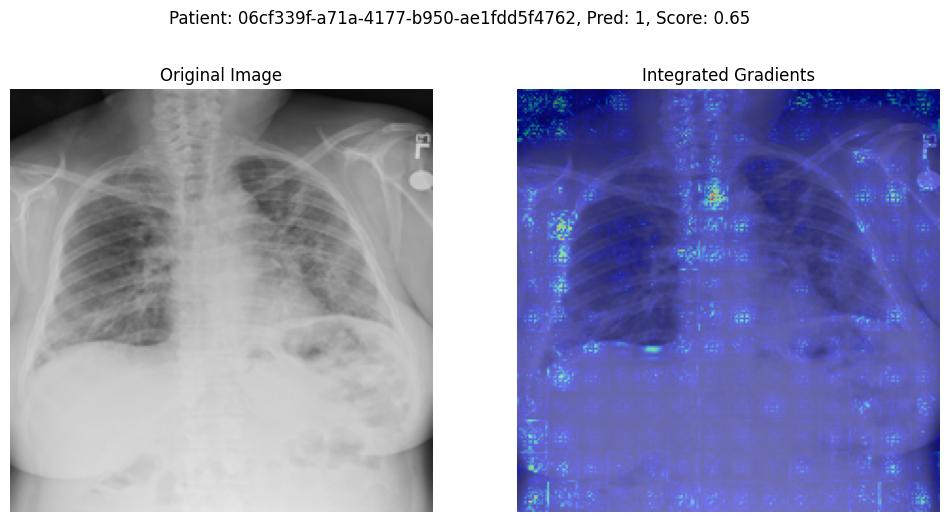

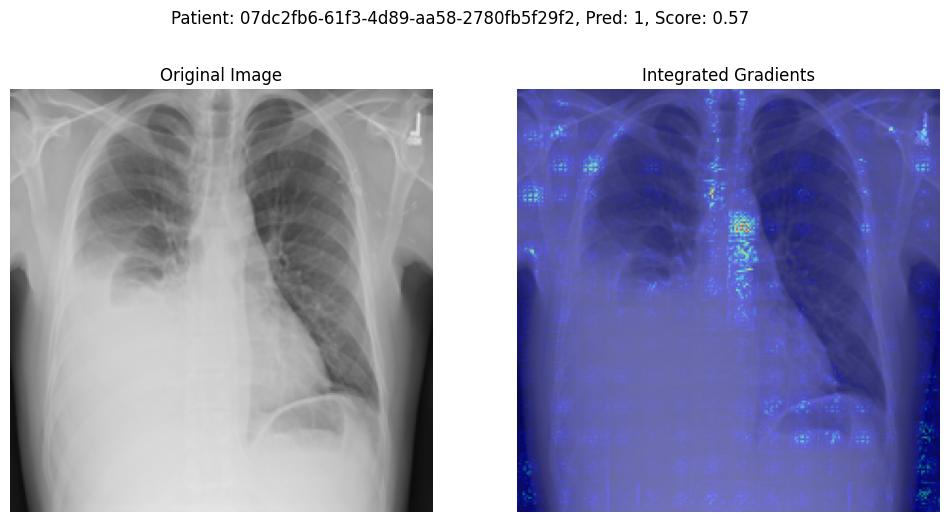

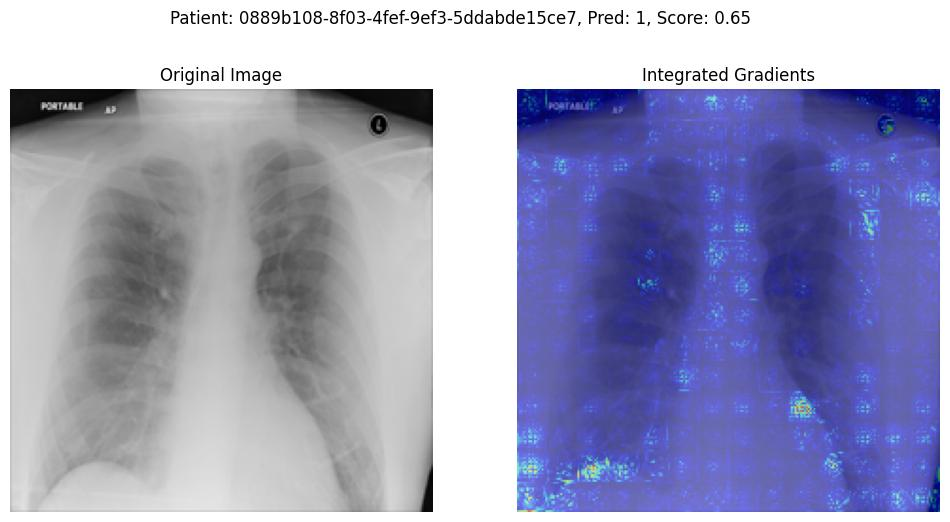

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from captum.attr import IntegratedGradients

# ---------------- Config ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 50
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

model_loc.eval()

# =======================
# 1️⃣ Wrap model for IG
# =======================
class IGWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        cls_out = self.model(x)  # no unpacking
        return cls_out


model_cls = IGWrapper(model_loc).to(DEVICE)
model_cls.eval()
ig = IntegratedGradients(model_cls)

# =======================
# 2️⃣ Loop over samples
# =======================
for pid in sample_files:
    img_path = f"{IMAGE_DIR}/{pid}.png"
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Prediction ----------
    with torch.no_grad():
        pred_logits = model_cls(img_tensor)
        pred_score = torch.sigmoid(pred_logits[0,0]).item()
        pred_class = int(pred_score > 0.5)

    # ---------- Compute IG ----------
    baseline = torch.zeros_like(img_tensor).to(DEVICE)
    target = 0  # explain the first (or only) output
    attributions = ig.attribute(img_tensor, baselines=baseline, target=target, n_steps=STEPS)


    attr = attributions.squeeze(0).cpu().detach().numpy()  # [3,H,W]
    attr = np.sum(np.abs(attr), axis=0)                     # sum over channels -> [H,W]
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # normalize 0-1

    # ---------- Heatmap ----------
    cmap = plt.get_cmap('jet')
    ig_heatmap = cmap(attr)[...,:3]  # drop alpha channel, [H,W,3]

    # ---------- Combine with original image ----------
    orig_img_np = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    combined = 0.5*orig_img_np + 0.5*ig_heatmap

    # ---------- Plot ----------
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    axes[0].imshow(orig_img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(combined)
    axes[1].set_title('Integrated Gradients')
    axes[1].axis('off')

    plt.suptitle(f"Patient: {pid}, Pred: {pred_class}, Score: {pred_score:.2f}")
    plt.show()
    plt.close(fig)



**Observations**:

Unlike Grad-CAM variants, the Integrated Gradients' heatmaps show noticeable changes after localization. The heatmaps have stronger activations around the lung region, indicating that these pixels contribute more than before to the model's predictions. This suggests that IG is more sensitive to the model's re-learned pixel level contribution, capturing the effect of localization more directly. 

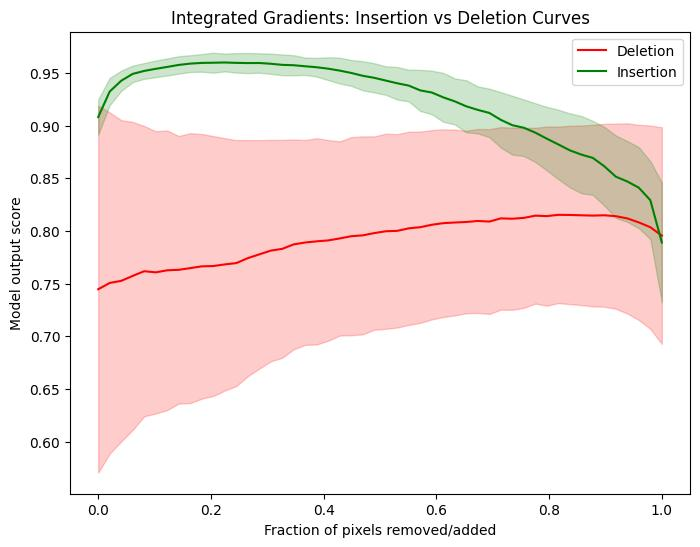

AUC Deletion: 0.7918, AUC Insertion: 0.9232
Average Heatmap Entropy: 10.410327
Average Heatmap Sparsity: 0.9933188509778911


In [ ]:
# =======================
# 1️⃣ Imports
# =======================
import os
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from torchvision import transforms

from captum.attr import IntegratedGradients
from sklearn.metrics import auc

# =======================
# 2️⃣ Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 50
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
TARGET_CLASS = 0  # pneumonia

# =======================
# 3️⃣ Transform & CSV
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 4️⃣ Blur baseline
# =======================
def blur_image_pil(img, radius=15):
    blurred = img.filter(ImageFilter.GaussianBlur(radius=radius))
    img_np = np.array(blurred)/255.0
    tensor = torch.tensor(img_np.transpose(2,0,1), dtype=torch.float32)
    return tensor.unsqueeze(0).to(DEVICE)

# =======================
# 5️⃣ IG Model Wrapper
# =======================
class IGWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        cls_out, _ = self.model(x)  # ignore patch embeddings
        return cls_out

ig_model = IGWrapper(model_loc).to(DEVICE)
ig = IntegratedGradients(ig_model)

# =======================
# 6️⃣ Metric functions
# =======================
def compute_entropy(mat):
    mat = mat / (mat.sum() + 1e-8)
    return -(mat * np.log(mat + 1e-8)).sum()

def compute_sparsity(mat, frac=0.95):
    """Fraction of pixels contributing less than `frac` of total attribution mass"""
    flat = mat.flatten()
    flat = np.sort(flat)
    cum_sum = np.cumsum(flat)
    total = cum_sum[-1]
    num_sparse = np.searchsorted(cum_sum, frac*total)
    return num_sparse / flat.size


# =======================
# 7️⃣ Run IG + curves
# =======================
del_curves, ins_curves = [], []
entropies, sparsities = [], []

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # baseline: all-zero
    baseline = torch.zeros_like(img_tensor).to(DEVICE)

    # ---------- Integrated Gradients ----------
    attr = ig.attribute(img_tensor, baselines=baseline, target=TARGET_CLASS)
    attr = attr.squeeze(0).permute(1,2,0).cpu().detach().numpy()  # H,W,C
    heatmap = np.sum(np.abs(attr), axis=2)
    heatmap = heatmap / (heatmap.max() + 1e-8)  # normalize

    # ---------- Entropy & Sparsity ----------
    entropies.append(compute_entropy(heatmap))
    sparsities.append(compute_sparsity(heatmap))

    # ---------- Flatten heatmap ----------
    flat_attr = heatmap.flatten()
    sort_idx = np.argsort(flat_attr)[::-1]  # top importance first

    # ---------- Deletion ----------
    del_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    scores = []
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = del_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = 0
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores.append(score)
    del_curves.append(scores)

    # ---------- Insertion ----------
    ins_img = np.zeros_like(del_img)
    scores = []
    for k in range(STEPS):
        num_pixels = int((k+1)/STEPS * flat_attr.size)
        temp_img = ins_img.copy().flatten()
        temp_img[sort_idx[:num_pixels]] = del_img.flatten()[sort_idx[:num_pixels]]
        temp_img = temp_img.reshape(del_img.shape)
        temp_tensor = transform(Image.fromarray((temp_img*255).astype(np.uint8))).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            score, _ = model_loc(temp_tensor)
            score = score.item()
        scores.append(score)
    ins_curves.append(scores)

# =======================
# 8️⃣ Average & plot curves
# =======================
del_mean = np.mean(del_curves, axis=0)
del_std = np.std(del_curves, axis=0)
ins_mean = np.mean(ins_curves, axis=0)
ins_std = np.std(ins_curves, axis=0)

x = np.linspace(0,1,STEPS)

plt.figure(figsize=(8,6))
plt.plot(x, del_mean, label='Deletion', color='red')
plt.fill_between(x, del_mean-del_std, del_mean+del_std, color='red', alpha=0.2)
plt.plot(x, ins_mean, label='Insertion', color='green')
plt.fill_between(x, ins_mean-ins_std, ins_mean+ins_std, color='green', alpha=0.2)
plt.xlabel("Fraction of pixels removed/added")
plt.ylabel("Model output score")
plt.title("Integrated Gradients: Insertion vs Deletion Curves")
plt.legend()
plt.show()

# =======================
# 9️⃣ Compute AUCs
# =======================
auc_del = auc(x, del_mean)
auc_ins = auc(x, ins_mean)
print(f"AUC Deletion: {auc_del:.4f}, AUC Insertion: {auc_ins:.4f}")

# =======================
#  🔟 Print entropy & sparsity
# =======================
print("Average Heatmap Entropy:", np.mean(entropies))
print("Average Heatmap Sparsity:", np.mean(sparsities))


**Observations**:

Before localization, IG heatmaps had a moderate Sparsity and moderate Entropy, indicating partial attention across lung regions. After localization, the Sparsity increased largely, while Entropy remained similar, reflecting that the model now concentrates almost entirely on the clinically relevant pixels. This demonstrates that IG captures the re-learned, focused contributions more effectively than Grad-CAM variants, which were visually similar before and after localization.

## Attention Rollout

**Concept**:

Attention Rollout aggregates attention weight across the transformer layers to visualize how information flows from the input token to the class token.

**Purpose**:

It is used to understand token-level attention propagation and to identify the spatial regions that are strongly integrated by the ViT.

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import os
import math
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 10
TOP_PERCENT = 0.2
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

model_loc.eval().to(DEVICE)

# =======================
# 2️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# =======================
# 3️⃣ Sample files
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 4️⃣ Attention Rollout class
# =======================
class AttentionRollout:
    def __init__(self, model, discard_ratio=0.9, head_fusion="mean"):
        self.model = model
        self.discard_ratio = discard_ratio
        self.head_fusion = head_fusion
        self.attentions = []

        # Register forward hooks for each block's attn
        for block in self.model.vit.blocks:
            block.attn.register_forward_hook(self._get_attention)

    def _get_attention(self, module, input, output):
        # timm ViT attention stores weights in module.attn.attn or module.attn.attn_drop.input
        if hasattr(module, 'attn_output_weights'):
            attn_weights = module.attn_output_weights
            if attn_weights is not None:
                self.attentions.append(attn_weights.detach())
        else:
            # fallback if attn weights not found
            pass

    def __call__(self, x):
        self.attentions = []
        _ = self.model(x)

        if not self.attentions:
            raise RuntimeError("No attention weights captured.")

        N = self.attentions[0].size(-1)
        result = torch.eye(N, device=x.device)

        for attention in self.attentions:
            # fuse heads
            if self.head_fusion == "mean":
                attn_heads_fused = attention.mean(dim=1)
            elif self.head_fusion == "max":
                attn_heads_fused = attention.max(dim=1)[0]
            else:
                raise ValueError("Unknown head_fusion")

            # drop low attention
            flat = attn_heads_fused.view(-1)
            k = int(flat.size(0)*(1-self.discard_ratio))
            if k > 0:
                _, indices = flat.topk(k, largest=False)
                flat[indices] = 0
            attn_heads_fused = flat.view(attn_heads_fused.size())
            result = torch.matmul(attn_heads_fused, result)

        return result

# =======================
# 5️⃣ Rollout to mask
# =======================
def rollout_to_mask(rollout, img_tensor, top_percent=TOP_PERCENT):
    mask = rollout(img_tensor)
    mask_no_cls = mask[0,0,1:]  # remove CLS token

    # keep top attention
    k = max(int(len(mask_no_cls)*top_percent), 1)
    threshold, _ = torch.kthvalue(mask_no_cls, len(mask_no_cls)-k)
    mask_no_cls = torch.where(mask_no_cls>=threshold, mask_no_cls, torch.zeros_like(mask_no_cls))

    # normalize
    mask_no_cls = mask_no_cls / (mask_no_cls.max() + 1e-8)

    # reshape to square
    side = int(math.sqrt(mask_no_cls.numel()) + 0.5)
    pad = side*side - mask_no_cls.numel()
    if pad>0:
        mask_no_cls = torch.cat([mask_no_cls, torch.zeros(pad, device=mask_no_cls.device)])
    mask_2d = mask_no_cls.reshape(1, 1, side, side)

    # interpolate to image size
    mask_img = F.interpolate(mask_2d, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)[0,0]
    return mask_img.detach().cpu().numpy()

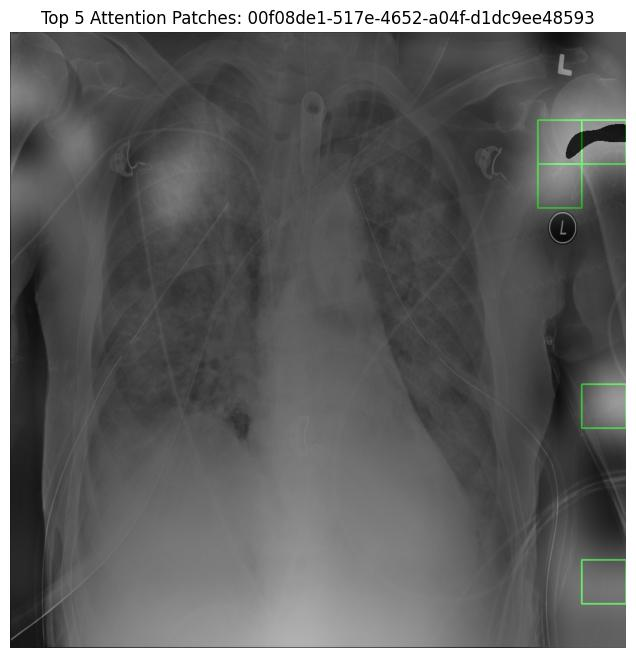

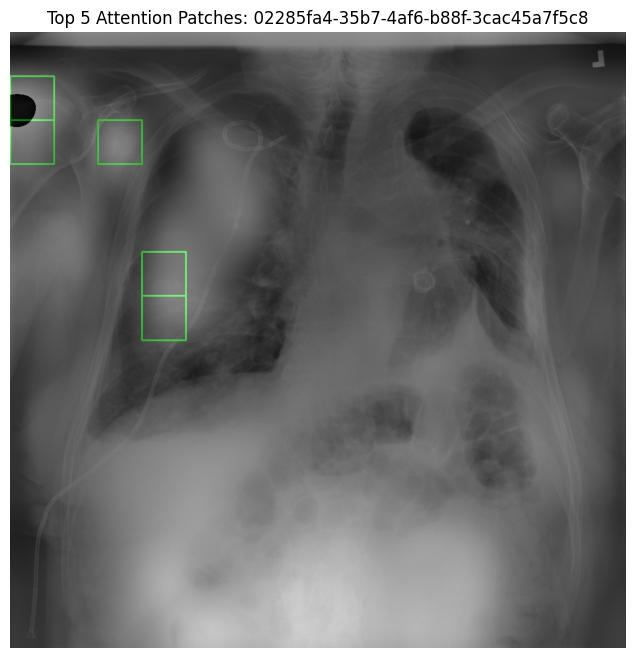

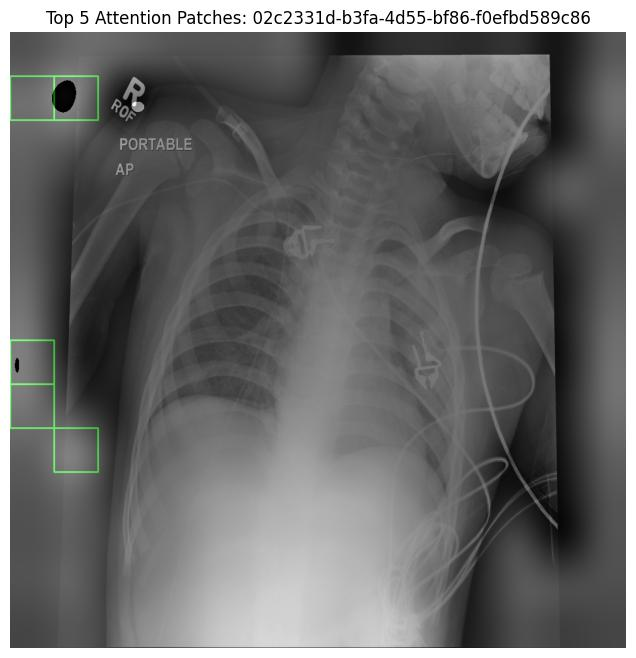

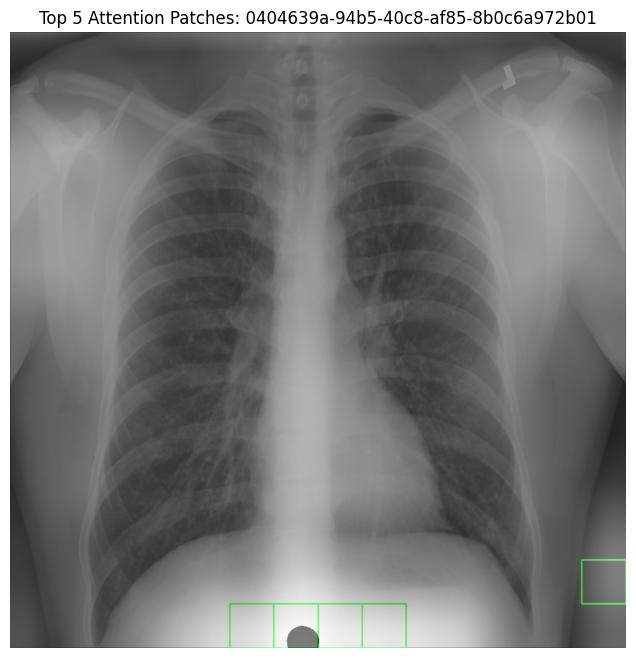

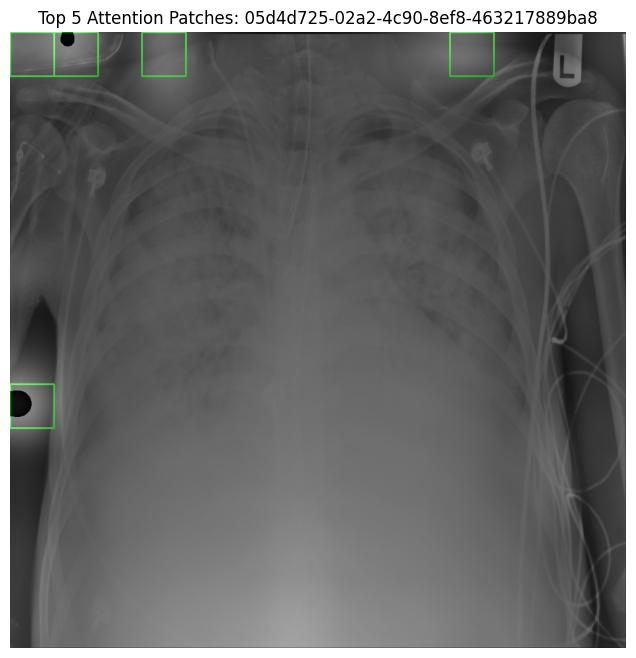

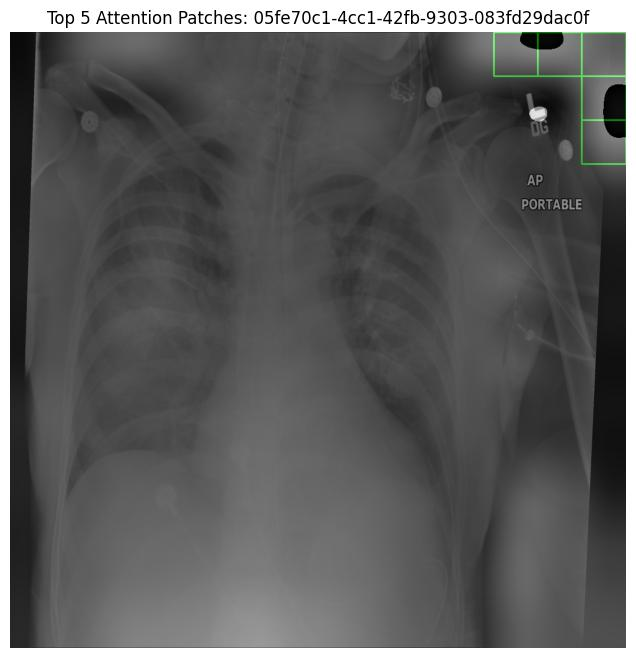

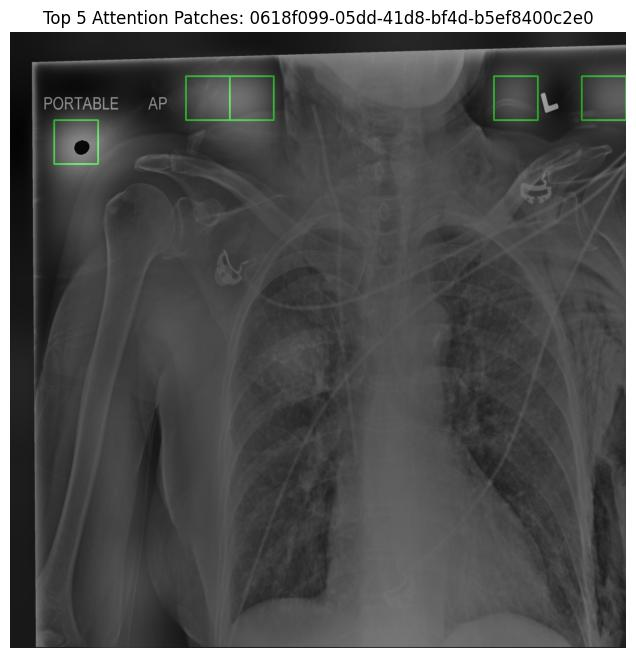

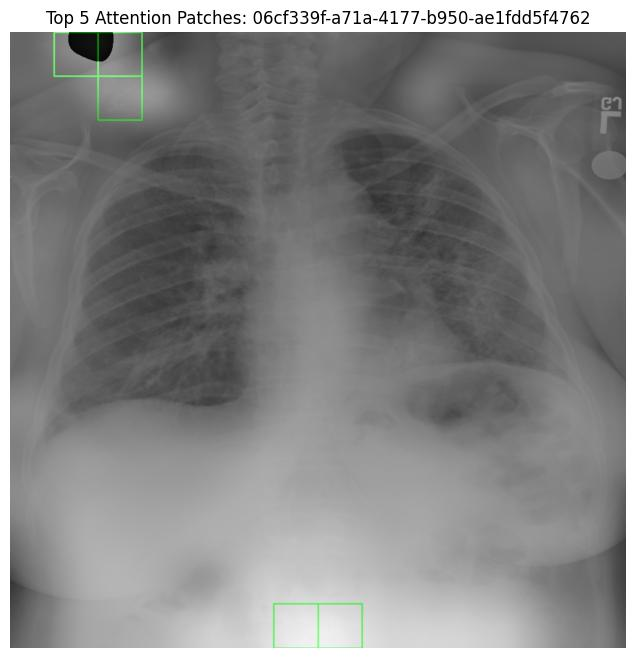

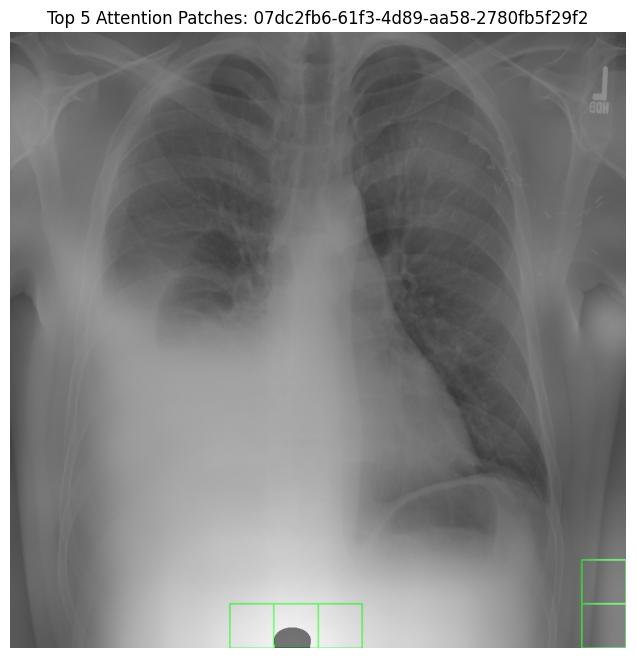

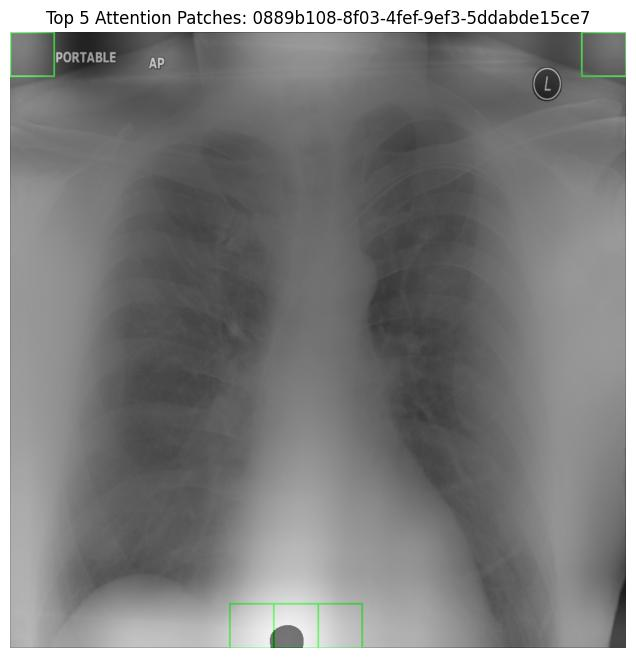

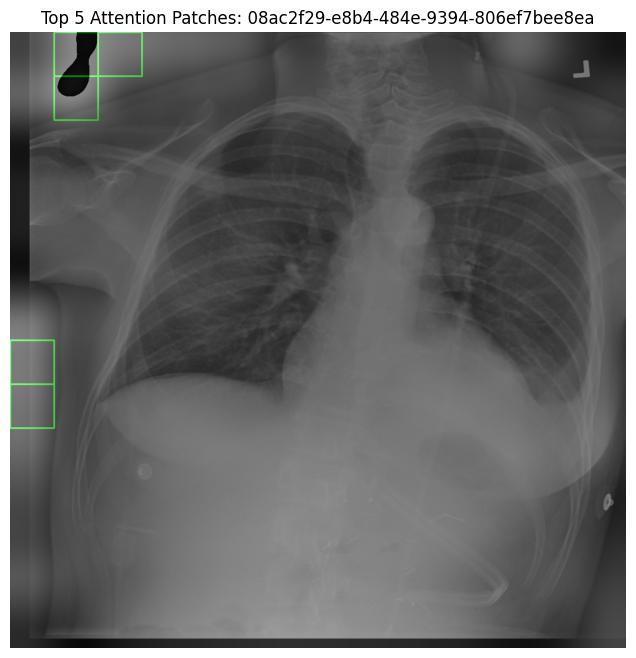

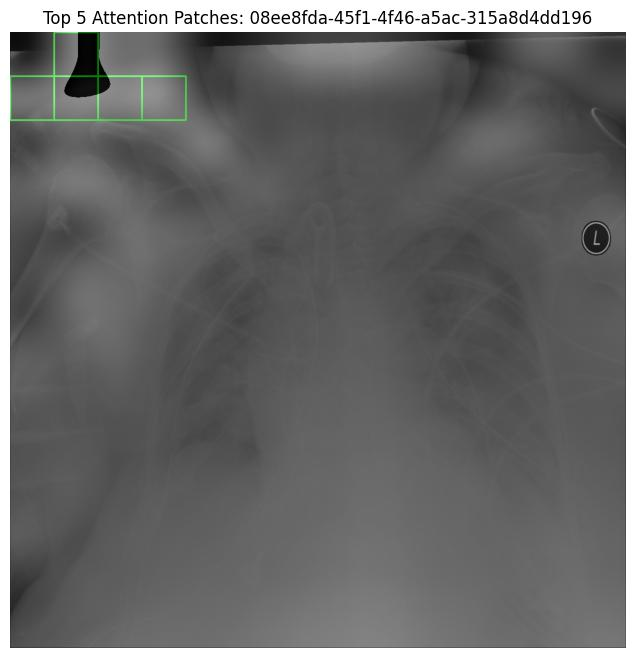

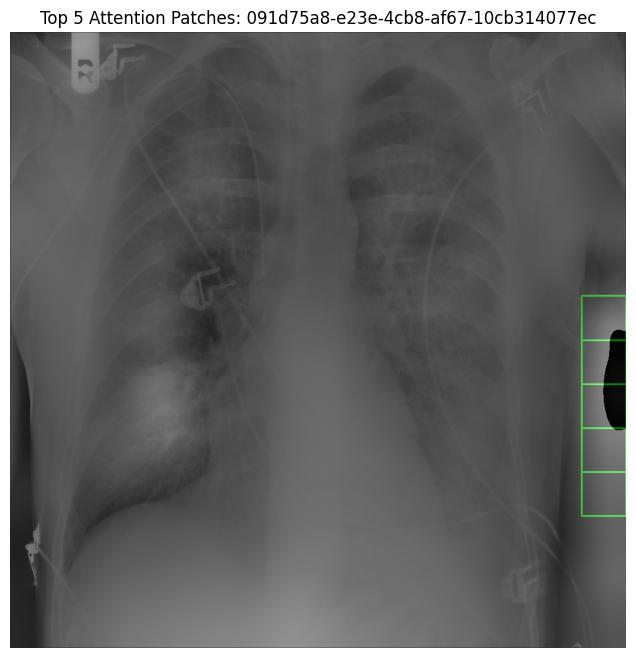

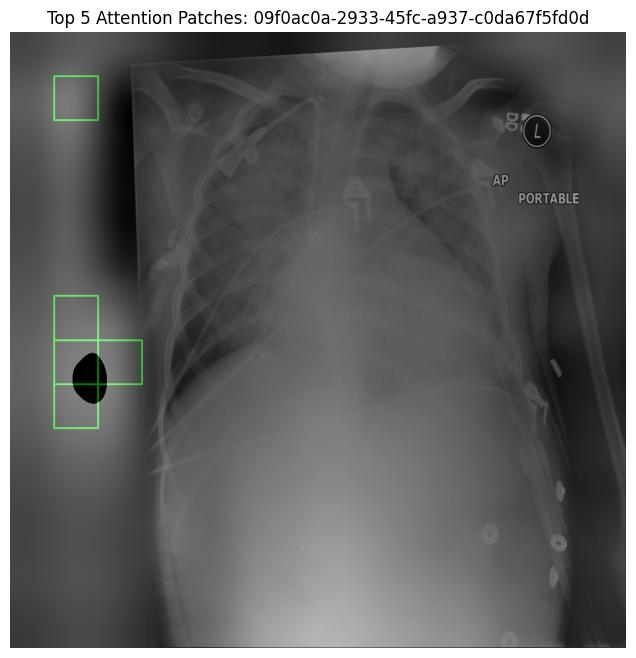

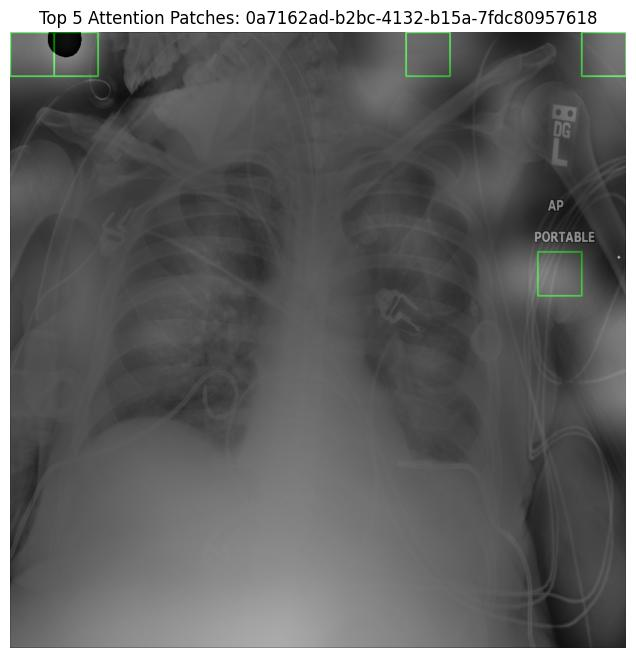

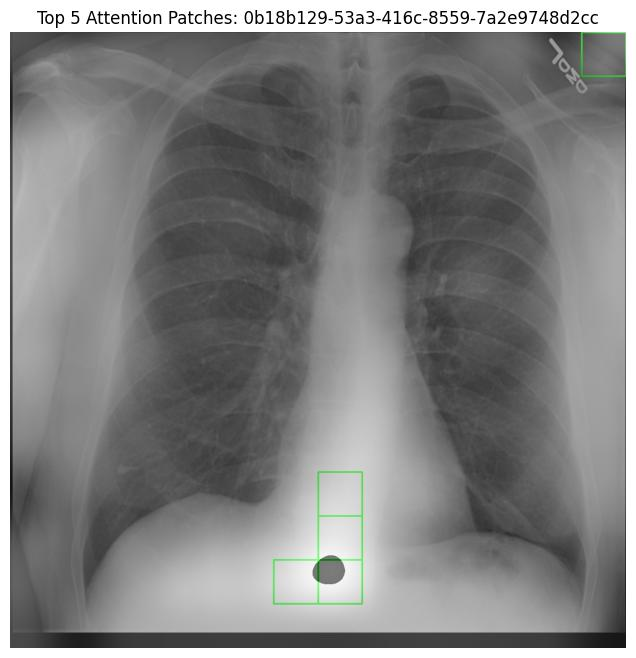

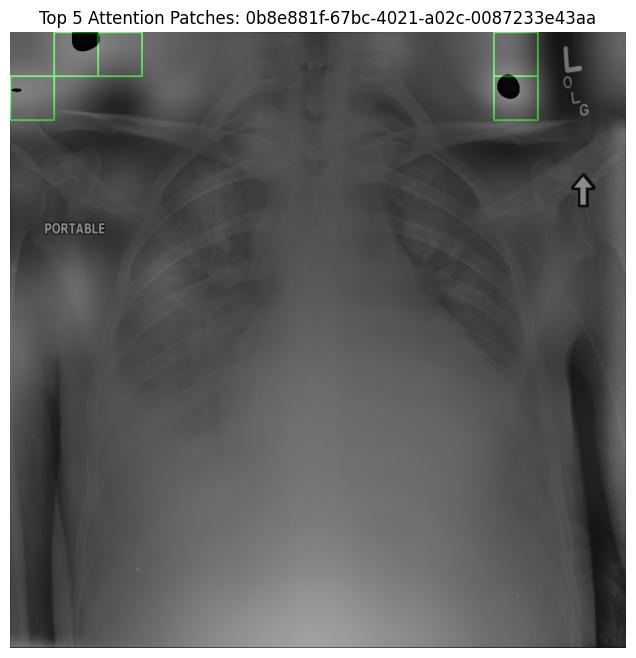

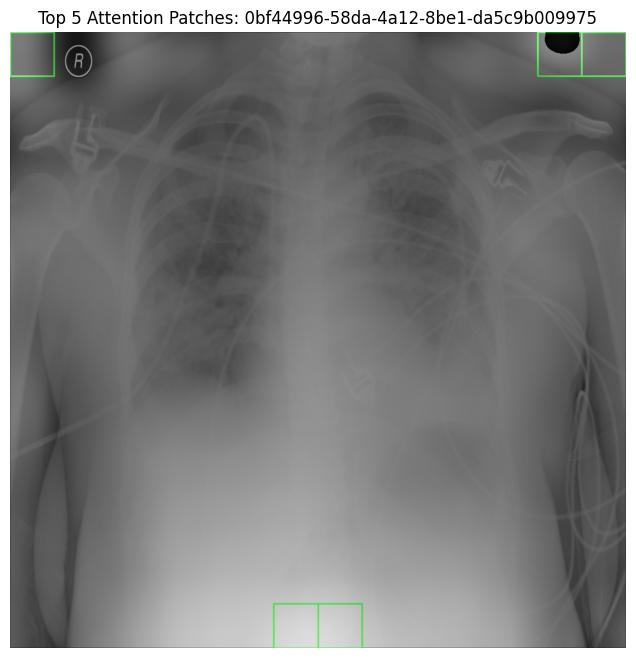

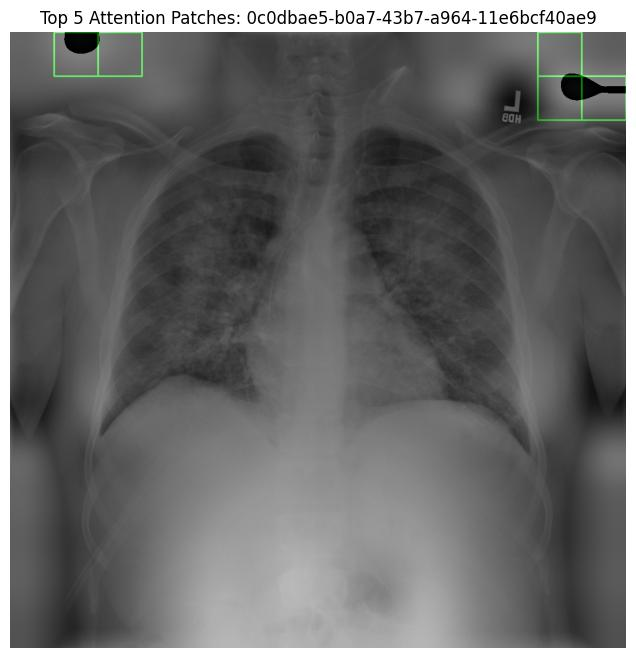

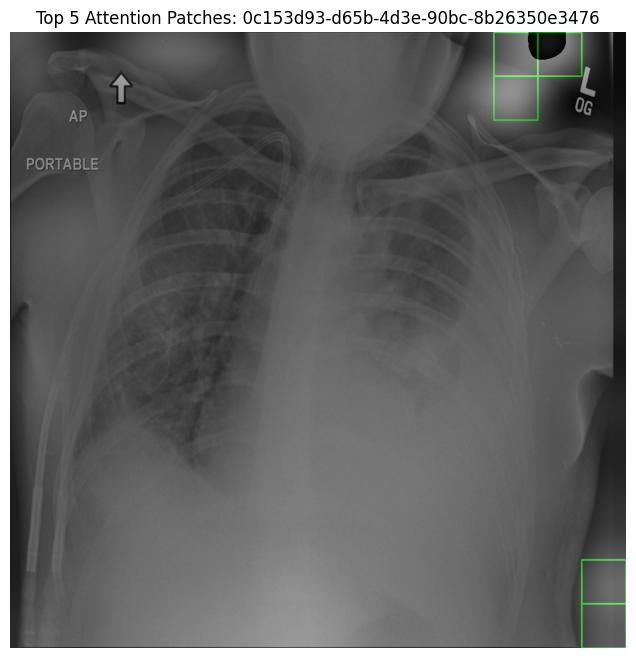

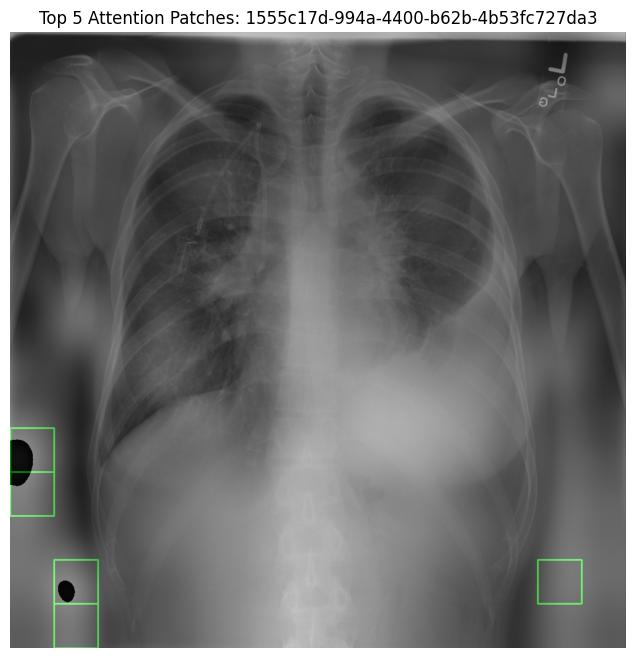

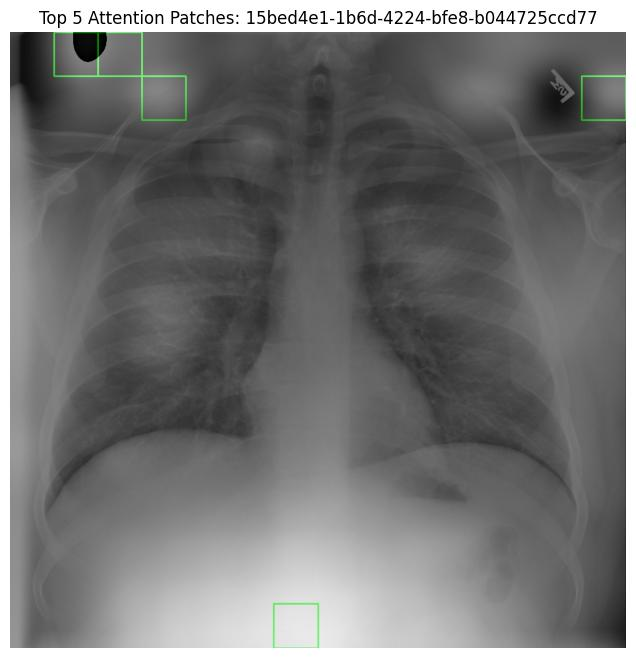

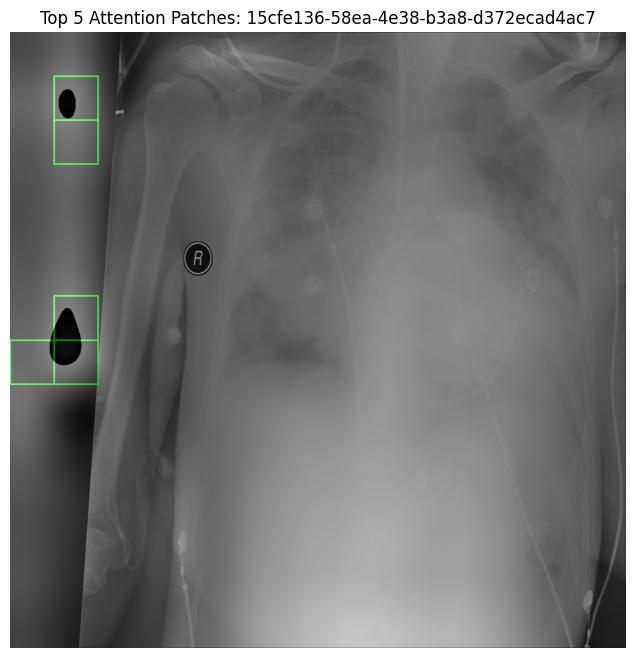

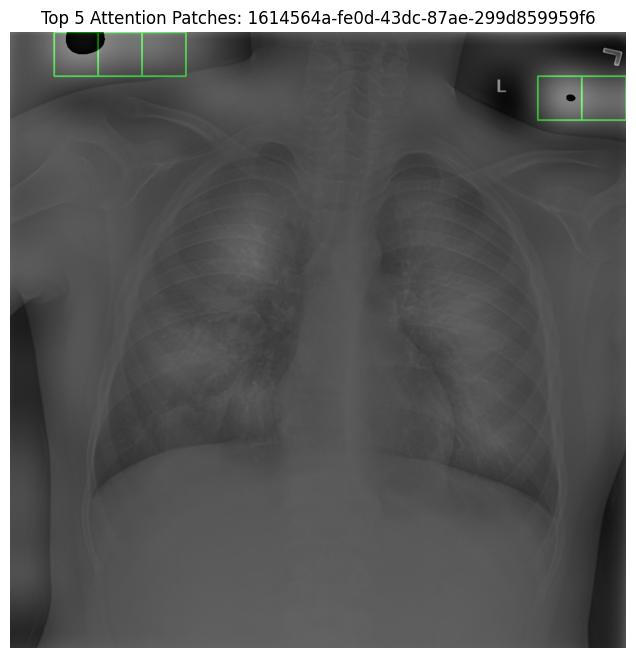

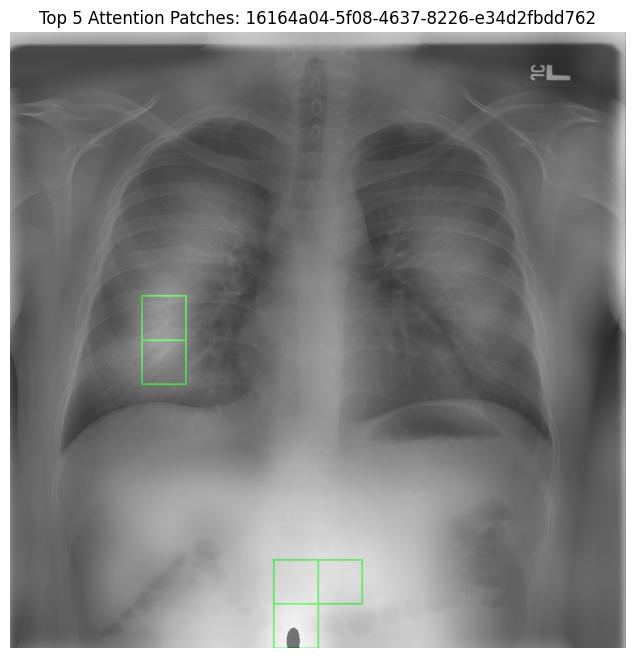

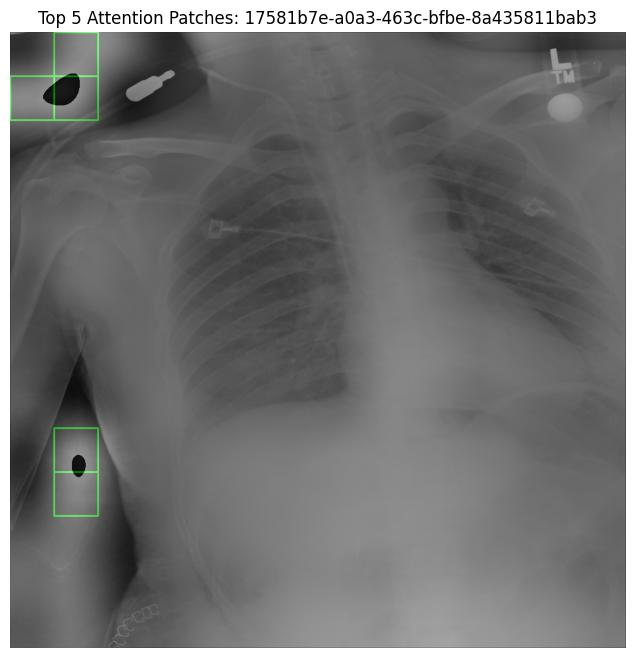

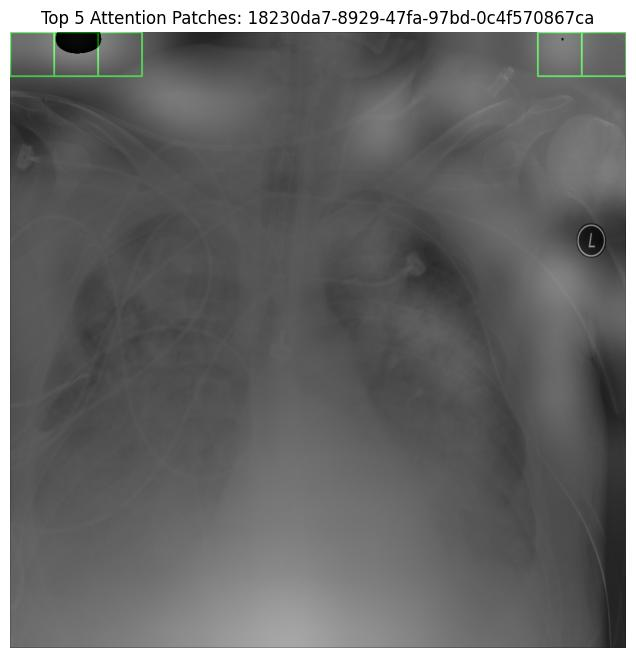

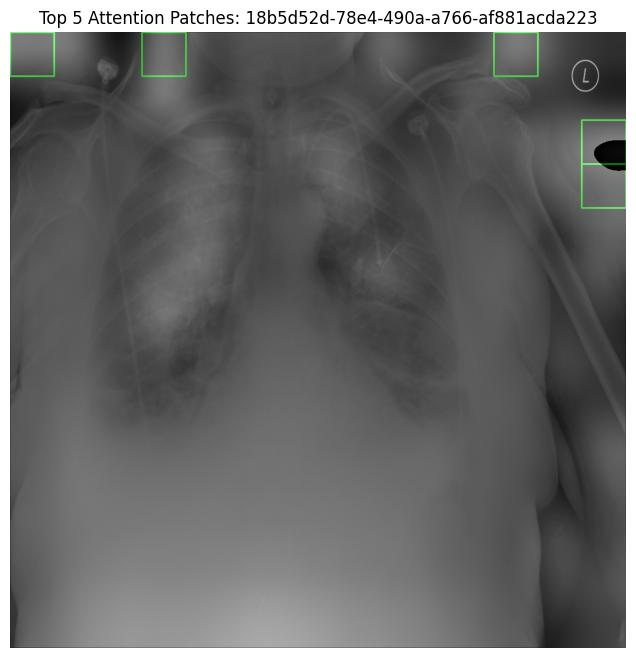

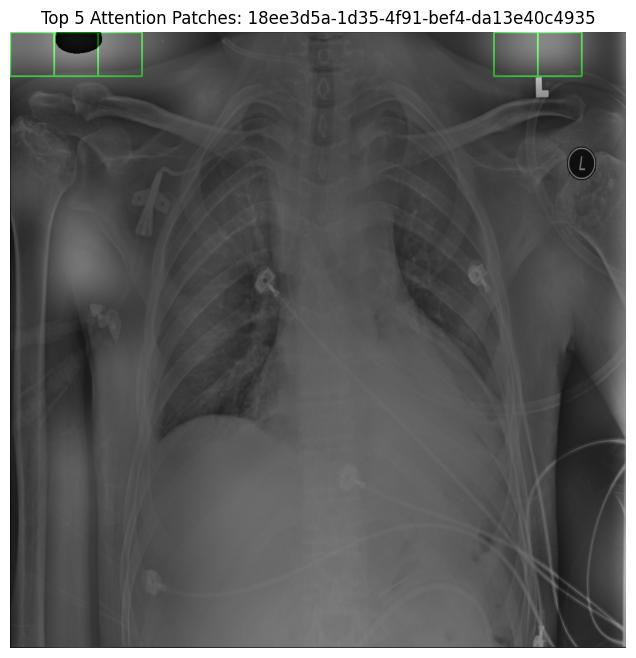

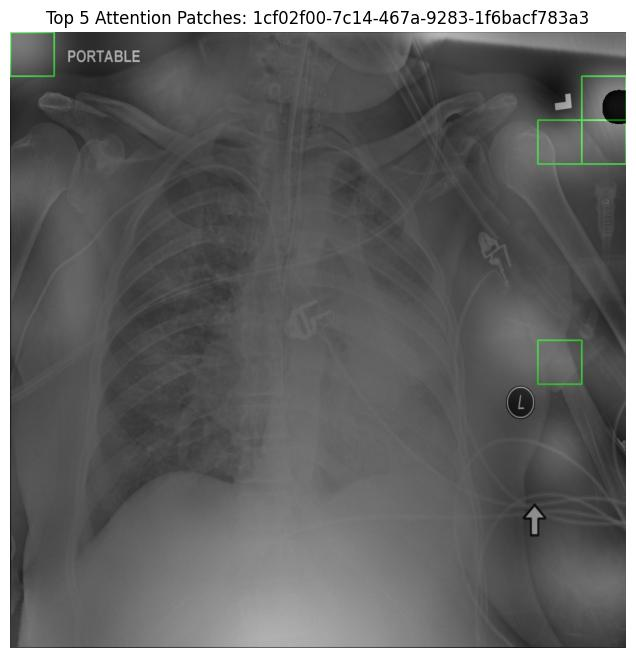

In [ ]:
# =======================
# Visualization: Top Patches + Blurred Attention Overlay
# =======================
rollout = AttentionRollout(model_loc, discard_ratio=0.0, head_fusion="mean")
top_k = 5  # number of top-attended patches to show

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_vis = np.array(pil_img).copy()  # original resolution
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # --- Get rollout mask ---
    mask = rollout(img_tensor)                     # N x N
    num_patches = mask.shape[1] - 1
    cls_row = mask[0, 1:]                          # CLS to all patches
    cls_row = cls_row / (cls_row.max() + 1e-8)    # normalize

    side = int(math.sqrt(num_patches))
    patch_grid = cls_row.reshape(side, side).detach().cpu().numpy()

    # --- Upsample patch map to image size ---
    mask_img = cv2.resize(patch_grid, (img_vis.shape[1], img_vis.shape[0]), interpolation=cv2.INTER_CUBIC)

    # --- Draw top-attended patches ---
    flat = patch_grid.flatten()
    top_indices = flat.argsort()[-top_k:]  # top-k patches
    for idx in top_indices:
        i, j = divmod(idx, side)
        x0 = int(j * img_vis.shape[1] / side)
        y0 = int(i * img_vis.shape[0] / side)
        x1 = int((j+1) * img_vis.shape[1] / side)
        y1 = int((i+1) * img_vis.shape[0] / side)
        cv2.rectangle(img_vis, (x0, y0), (x1, y1), (0, 255, 0), 2)  # green box

    # --- Blurred overlay for context ---
    mask_blur = cv2.GaussianBlur(mask_img, (21,21), 0)
    overlay = (0.5 * img_vis + 0.5 * np.uint8(255*mask_blur[...,None])).astype(np.uint8)

    # --- Show ---
    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title(f"Top {top_k} Attention Patches: {pid}")
    plt.axis("off")
    plt.show()


**Observations**:

The top 5 attention patches remain the same before and after localization. This occurs because the ViT's global attention mechanism assigns patch-level importance based on the backbone features, which doesn't substantially change with the addition of a localization head. Consequently, the most "communicative" patches remain consistently prioritized. 

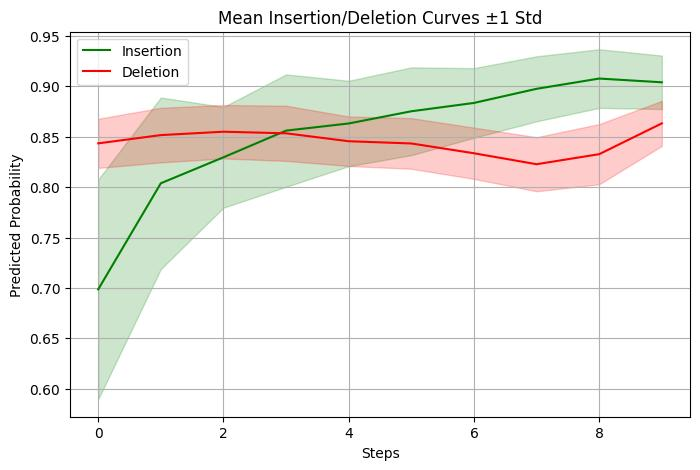

Entropy: 10.7611 ± 0.0247
Sparsity: 0.9500 ± 0.0000
Insertion AUC: 7.7185 ± 0.1909
Deletion AUC: 7.5917 ± 0.1669


In [ ]:
from sklearn.metrics import auc
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# --- Config ---
steps = 10  # number of steps for insertion/deletion curves
percentile_thresh = 95  # top X% considered "important" for sparsity

entropies, sparsities = [], []
all_prob_insertion, all_prob_deletion = [], []
all_insertion_aucs, all_deletion_aucs = [], []

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # --- Attention Rollout ---
    mask_img = rollout_to_mask_smooth(rollout, img_tensor, final_size=IMG_SIZE, blur=True)

    # --- Entropy & Sparsity ---
    flat_norm = mask_img.ravel() / mask_img.sum()
    entropy = -np.sum(flat_norm * np.log(flat_norm + 1e-8))
    threshold_value = np.percentile(mask_img, percentile_thresh)
    sparsity = (mask_img < threshold_value).sum() / mask_img.size
    entropies.append(entropy)
    sparsities.append(sparsity)

    # --- Insertion Curve ---
    baseline = torch.zeros_like(img_tensor)
    prob_insertion = []

    # negative stride fix
    indices = np.argsort(mask_img.ravel())[::-1].copy()  # top-attention first
    step_size = len(indices) // steps

    for i in range(steps):
        start = i*step_size
        end = len(indices) if i == steps-1 else (i+1)*step_size
        idxs = indices[start:end]
        idxs_tensor = torch.tensor(idxs, device=img_tensor.device)

        baseline_flat = baseline.contiguous().view(-1)
        img_flat = img_tensor.contiguous().view(-1)
        baseline_flat[idxs_tensor] = img_flat[idxs_tensor]

        with torch.no_grad():
            pred = model_loc(baseline)
            # use predicted class probability
            pred_class = pred.argmax(dim=1)
            prob = pred.softmax(dim=1)[0, pred_class]
        prob_insertion.append(prob.item())

    all_prob_insertion.append(prob_insertion)
    all_insertion_aucs.append(auc(range(steps), prob_insertion))

    # --- Deletion Curve ---
    img_mod = img_tensor.clone()
    prob_deletion = []

    for i in range(steps):
        start = i*step_size
        end = len(indices) if i == steps-1 else (i+1)*step_size
        idxs = indices[start:end]
        idxs_tensor = torch.tensor(idxs, device=img_tensor.device)

        img_flat = img_mod.contiguous().view(-1)
        img_flat[idxs_tensor] = 0

        with torch.no_grad():
            pred = model_loc(img_mod)
            pred_class = pred.argmax(dim=1)
            prob = pred.softmax(dim=1)[0, pred_class]
        prob_deletion.append(prob.item())

    all_prob_deletion.append(prob_deletion)
    all_deletion_aucs.append(auc(range(steps), prob_deletion))

# --- Convert to numpy arrays ---
all_prob_insertion = np.array(all_prob_insertion)
all_prob_deletion = np.array(all_prob_deletion)

# --- Compute mean and std ---
mean_insertion = all_prob_insertion.mean(axis=0)
std_insertion = all_prob_insertion.std(axis=0)
mean_deletion = all_prob_deletion.mean(axis=0)
std_deletion = all_prob_deletion.std(axis=0)

# --- Plot mean curves with std ---
plt.figure(figsize=(8,5))
x = np.arange(steps)
plt.plot(x, mean_insertion, label="Insertion", color='green')
plt.fill_between(x, mean_insertion - std_insertion, mean_insertion + std_insertion, color='green', alpha=0.2)

plt.plot(x, mean_deletion, label="Deletion", color='red')
plt.fill_between(x, mean_deletion - std_deletion, mean_deletion + std_deletion, color='red', alpha=0.2)

plt.title("Mean Insertion/Deletion Curves ±1 Std")
plt.xlabel("Steps")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.show()

# --- Summary ---
print(f"Entropy: {np.mean(entropies):.4f} ± {np.std(entropies):.4f}")
print(f"Sparsity: {np.mean(sparsities):.4f} ± {np.std(sparsities):.4f}")
print(f"Insertion AUC: {np.mean(all_insertion_aucs):.4f} ± {np.std(all_insertion_aucs):.4f}")
print(f"Deletion AUC: {np.mean(all_deletion_aucs):.4f} ± {np.std(all_deletion_aucs):.4f}")


**Observations**:

For attention rollout, apart from the top patches, the Entropy and Sparsity also remain largely similar before and after localization. However, the Insertion and Deletion curves now behave intuitively: the Insertion curve gradually increases while the Deletion curve gradually decreases. This indicates that localization improves the relevance of the top attention patches, even though the patch selection itself does not change.